In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [74]:
#library required
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text
import os
import time 
from datetime import datetime
import io 
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error


In [75]:
#Load the data

# Define the file path
file_path = r"C:\Users\Poovesh Kumar M\Downloads\Planning\1_Data\2_Sep_02_09_2024\majestic pure_Amazon_com_weekly_data.csv"

# Read the CSV file into a DataFrame
df_base = pd.read_csv(file_path)

# Display the DataFrame
print(df_base)



      velocity_bucket        asin Week_Start_date Week_End_date  \
0                1_SF  B00PMR3QF2      2022-09-26    2022-10-02   
1                1_SF  B00PMR3QF2      2022-10-03    2022-10-09   
2                1_SF  B00PMR3QF2      2022-10-10    2022-10-16   
3                1_SF  B00PMR3QF2      2022-10-17    2022-10-23   
4                1_SF  B00PMR3QF2      2022-10-24    2022-10-30   
...               ...         ...             ...           ...   
29805            4_SM  B0D8HVYNM8      2024-07-29    2024-08-04   
29806            4_SM  B0D8HVYNM8      2024-08-05    2024-08-11   
29807            4_SM  B0D8HVYNM8      2024-08-12    2024-08-18   
29808            4_SM  B0D8HVYNM8      2024-08-19    2024-08-25   
29809            4_SM  B0D8HVYNM8      2024-08-26    2024-09-01   

       organic_gmv_units  inorganic_gmv_units   asp_week   ad_spend  \
0               220.8734             145.9917  18.886359  1626.1800   
1               756.0293             464.0168  18.895

In [76]:
df_weekly = df_base

# Convert 'Week_Start_date' to datetime format
df_weekly['Week_Start_date'] = pd.to_datetime(df_weekly['Week_Start_date'])

# Replace NaN values in 'asp_week' column with 0
df_weekly['asp_week'] = df_weekly['asp_week'].fillna(0)


In [77]:
#creating New DF 
df_bs1 = df_weekly
# Display the first few rows of the filtered DataFrame
print(df_bs1.head())

#creating ASINx VB for mapping purpose
# Remove rows where 'asin' is null
df_asin_vb = df_bs1.dropna(subset=['asin'])

# Select distinct 'asin' and 'velocity_bucket' combinations
df_asin_vb = df_asin_vb[['asin', 'velocity_bucket']].drop_duplicates()

# Display the resulting DataFrame
print("Distinct asin x velocity_bucket:")
print(df_asin_vb.head())




  velocity_bucket        asin Week_Start_date Week_End_date  \
0            1_SF  B00PMR3QF2      2022-09-26    2022-10-02   
1            1_SF  B00PMR3QF2      2022-10-03    2022-10-09   
2            1_SF  B00PMR3QF2      2022-10-10    2022-10-16   
3            1_SF  B00PMR3QF2      2022-10-17    2022-10-23   
4            1_SF  B00PMR3QF2      2022-10-24    2022-10-30   

   organic_gmv_units  inorganic_gmv_units   asp_week   ad_spend  \
0           220.8734             145.9917  18.886359  1626.1800   
1           756.0293             464.0168  18.895069  4042.8753   
2           834.9785             813.4476  16.091245  6729.7078   
3           883.1982             597.8767  16.000302  4171.1138   
4          1034.3934             694.0630  16.050614  4477.2391   

   inventory_Availability%       gmv  inorganic_gmv  organic_gmv  gmv_units  \
0                      0.0   6950.18      2757.6640    4171.0360        368   
1                      0.0  23184.25      8768.5915   14284.

# Define the Outlier Treatment Function 


# Define a function to replace outliers with the previous week's value and track the changes
def replace_outliers_with_previous_week(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Track indices of outliers
    outlier_indices = group.index[outliers].tolist()
    
    # Replace outliers with the previous week's value
    group[column] = np.where(outliers, group[column].shift(1), group[column])
    
    # In case the first value is an outlier and has no previous week to reference, we can forward fill
    group[column] = group[column].fillna(method='ffill')
    
    return group, outlier_indices

# Apply the Function for Each 'asin' and Each Target Column
outliers_info = {'asin': [], 'gmv_units': [], 'organic_gmv_units': [], 'inorganic_gmv_units': []}

def apply_outlier_treatment(df, column):
    outliers_list = []
    df_grouped = df.groupby('asin')
    for name, group in df_grouped:
        treated_group, outlier_indices = replace_outliers_with_previous_week(group, column)
        outliers_list.extend(outlier_indices)
        df.update(treated_group)
    
    outliers_info['asin'].extend(df['asin'].loc[outliers_list].values)
    outliers_info[column].extend(outliers_list)

apply_outlier_treatment(df_weekly, 'gmv_units')
apply_outlier_treatment(df_weekly, 'organic_gmv_units')
apply_outlier_treatment(df_weekly, 'inorganic_gmv_units')

# Display the DataFrame after outlier treatment
print("DataFrame after outlier treatment:")
print(df_weekly[['Week_Start_date', 'asin', 'gmv_units', 'organic_gmv_units', 'inorganic_gmv_units']])

# Display the outliers tracked
print("\nOutliers tracked before and after treatment:")
print(outliers_info)


# Define a function to replace outliers using forward fill
def replace_outliers_ffill(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Replace outliers with NaN
    group.loc[outliers, column] = np.nan
    
    # Fill NaN values with the previous week's value
    group[column] = group[column].ffill()
    
    return group

# Apply the function for each 'asin' and each target column
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'organic_gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'inorganic_gmv_units').reset_index(drop=True)

# Display the DataFrame after outlier treatment
print("DataFrame after outlier treatment with ffill:")
print(df_weekly[['Week_Start_date', 'asin', 'gmv_units', 'organic_gmv_units', 'inorganic_gmv_units']])


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_23156\70521137.py:27: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'gmv_units').reset_index(drop=True)
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_23156\70521137.py:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and s

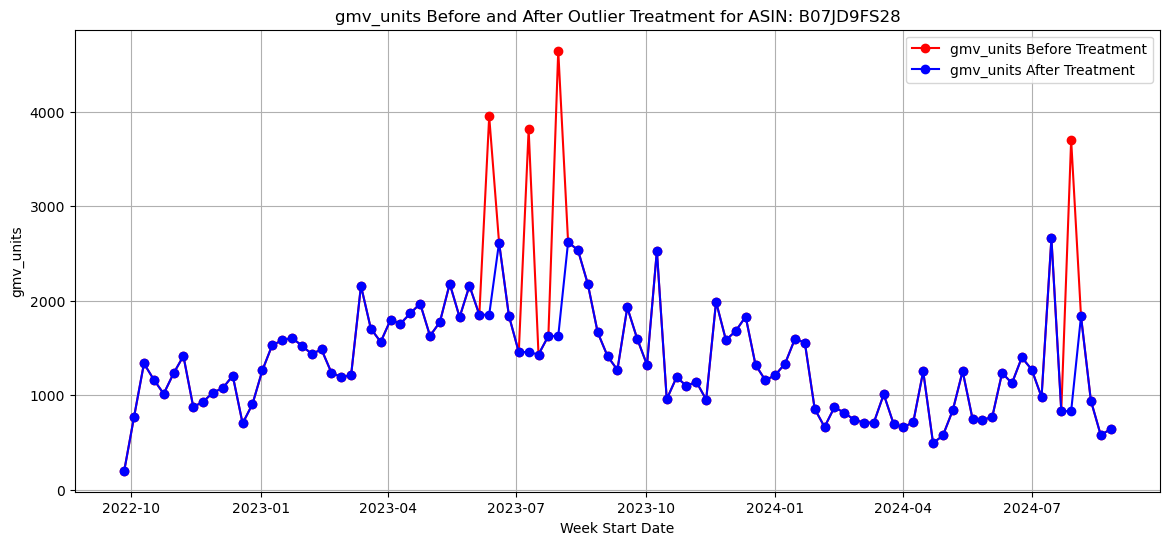

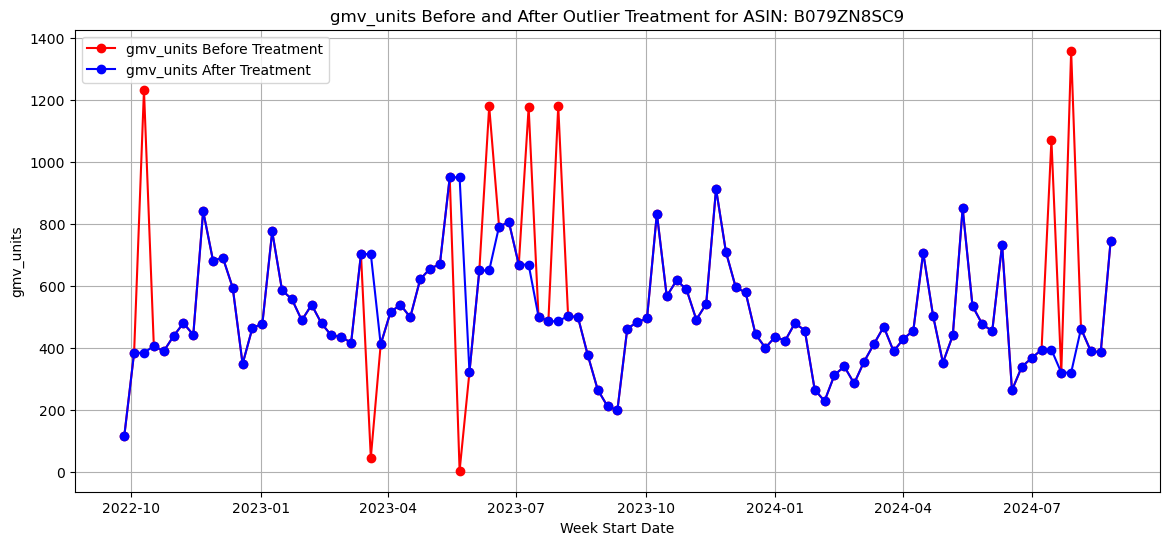

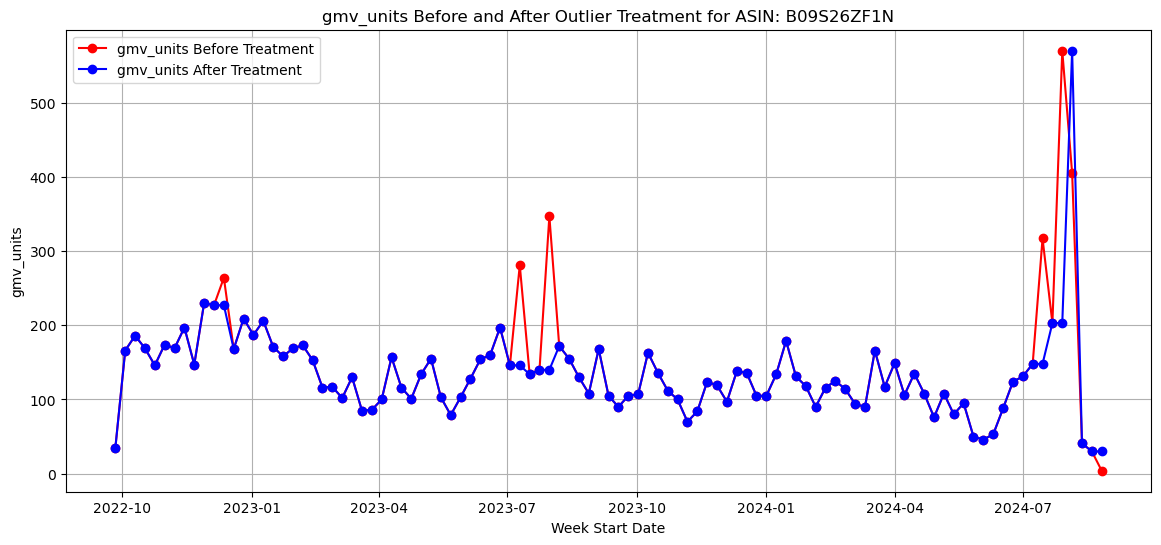

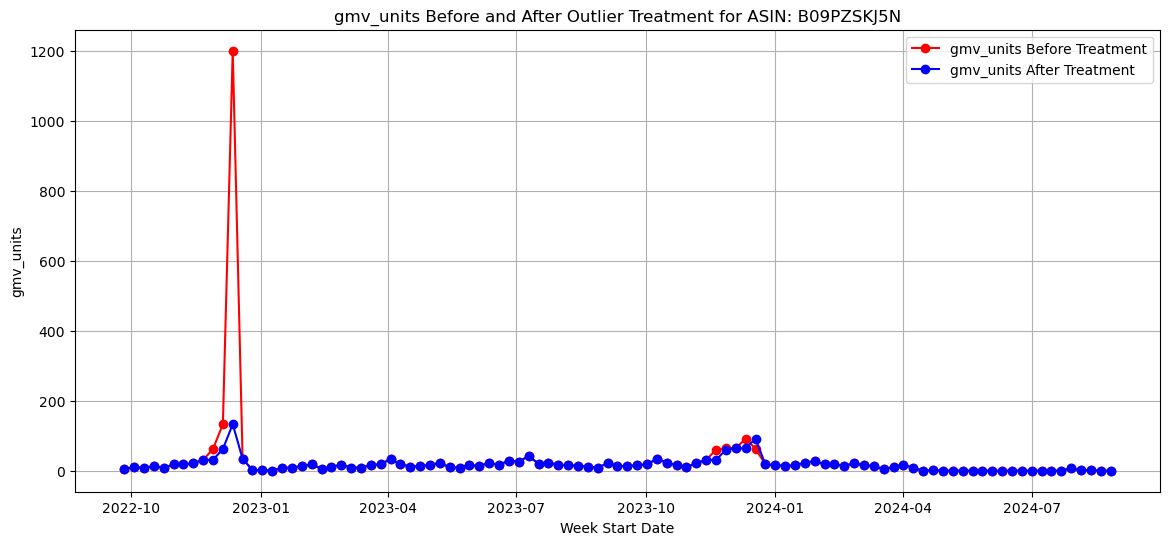

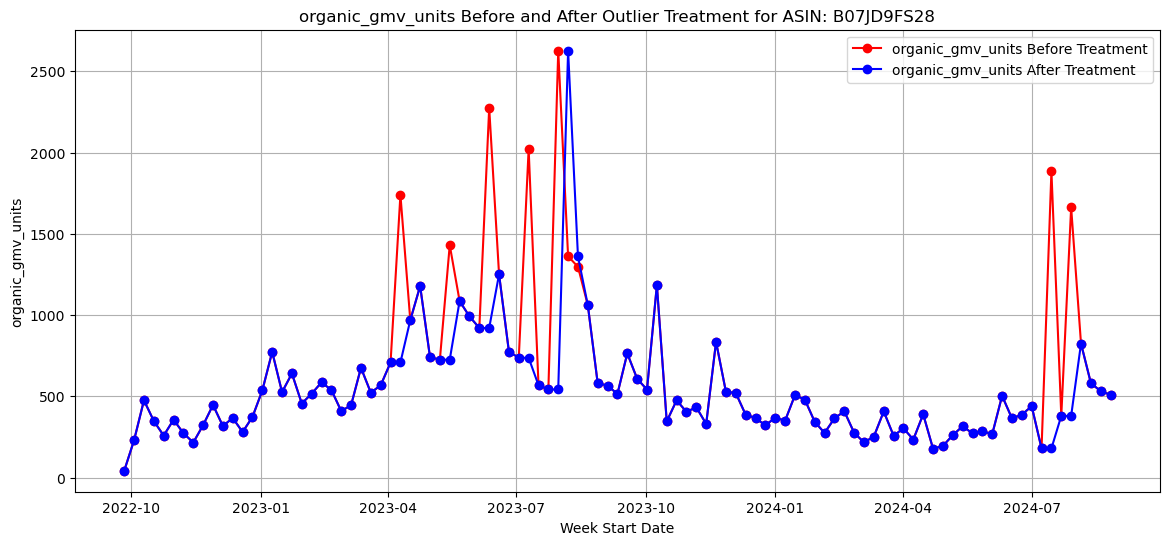

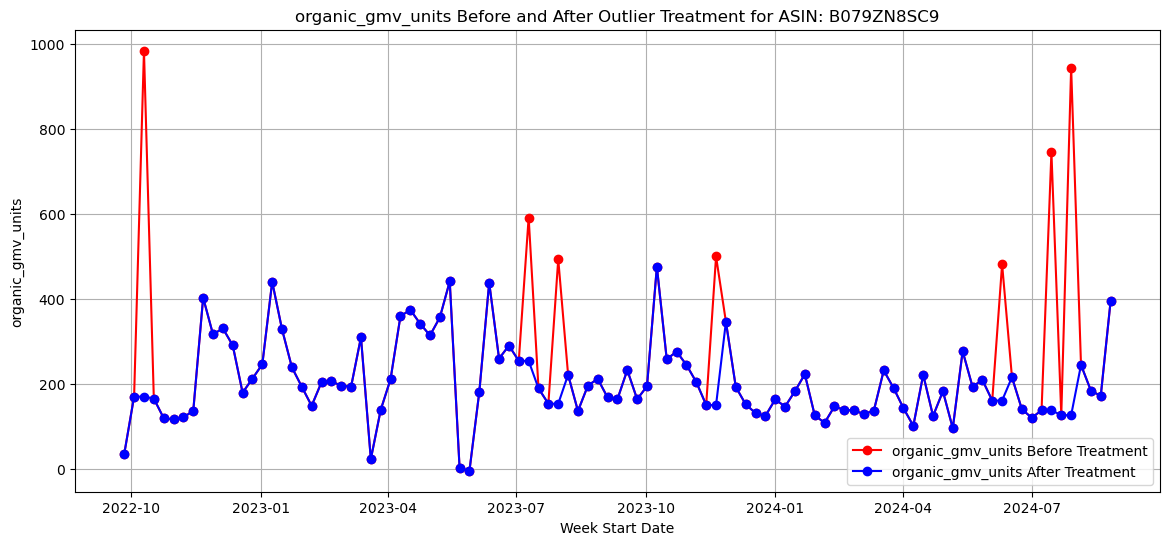

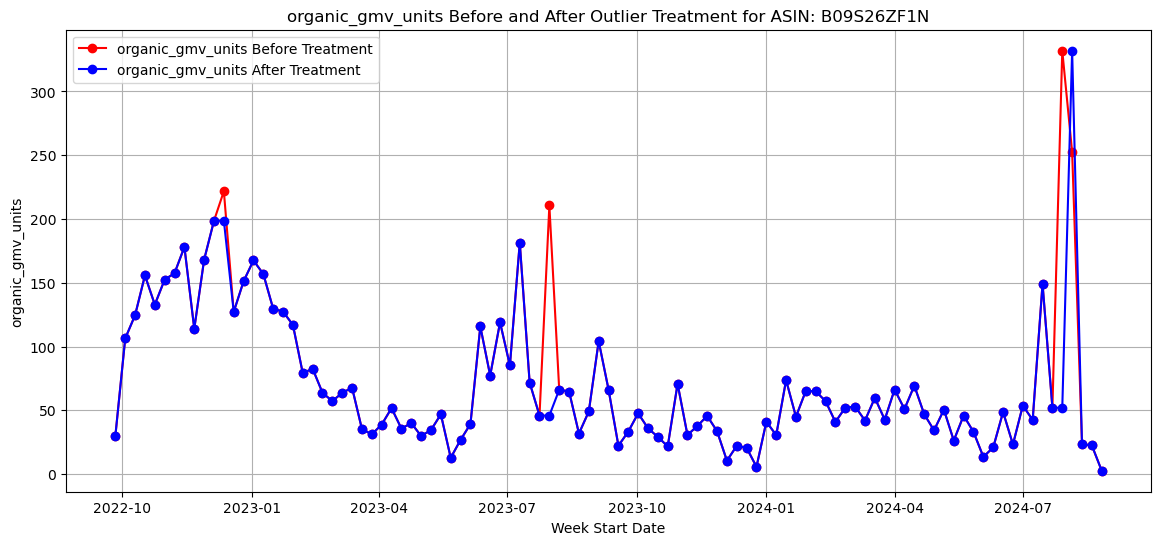

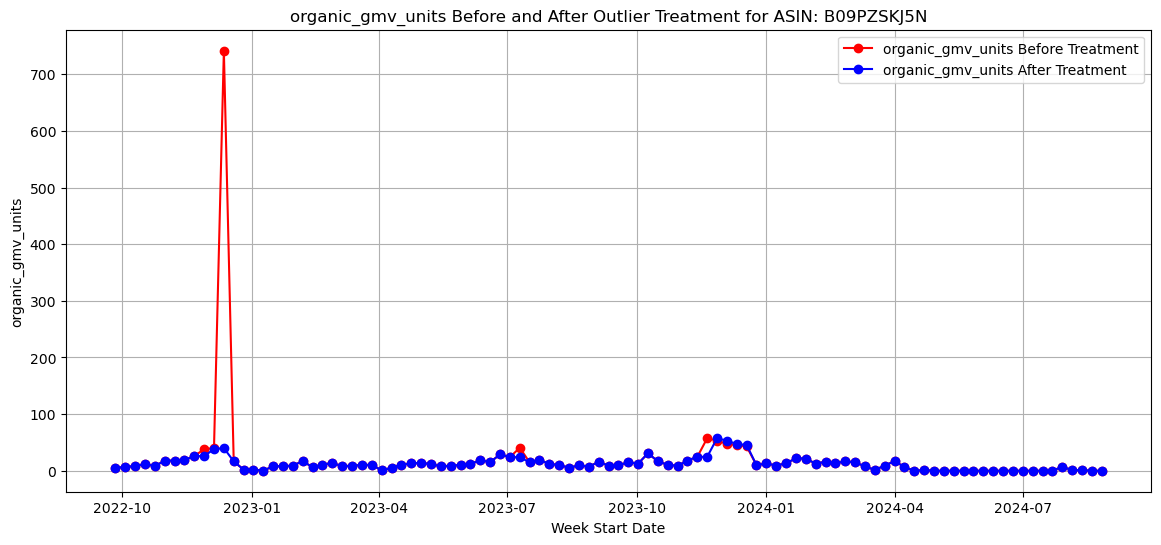

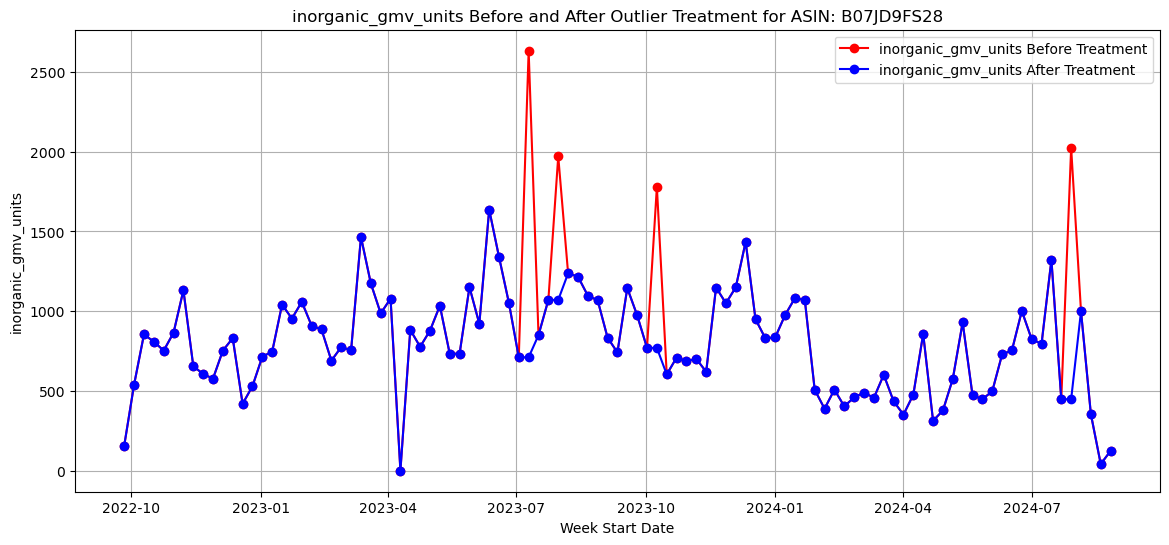

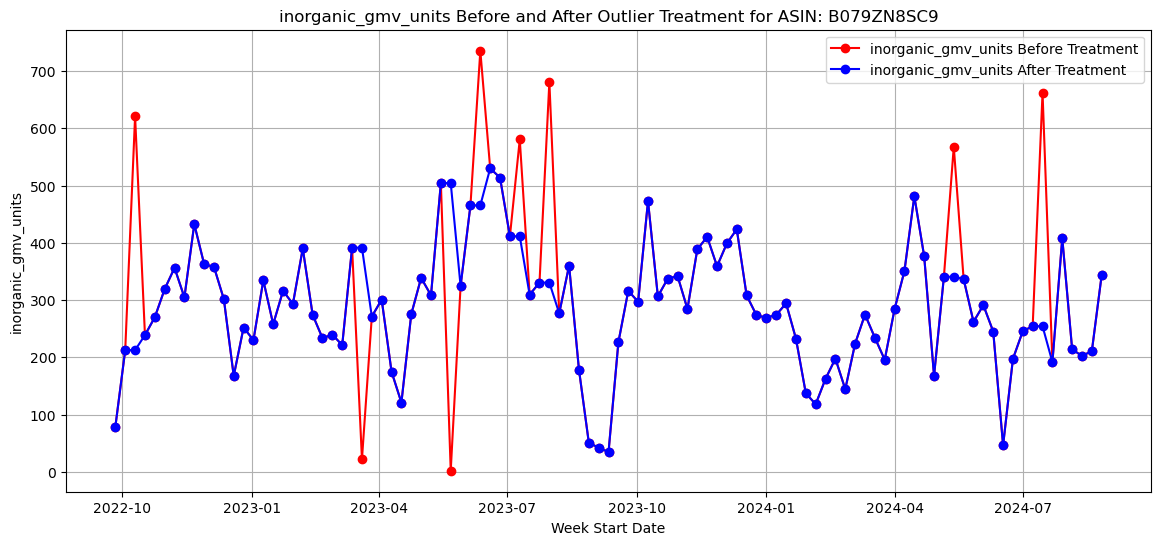

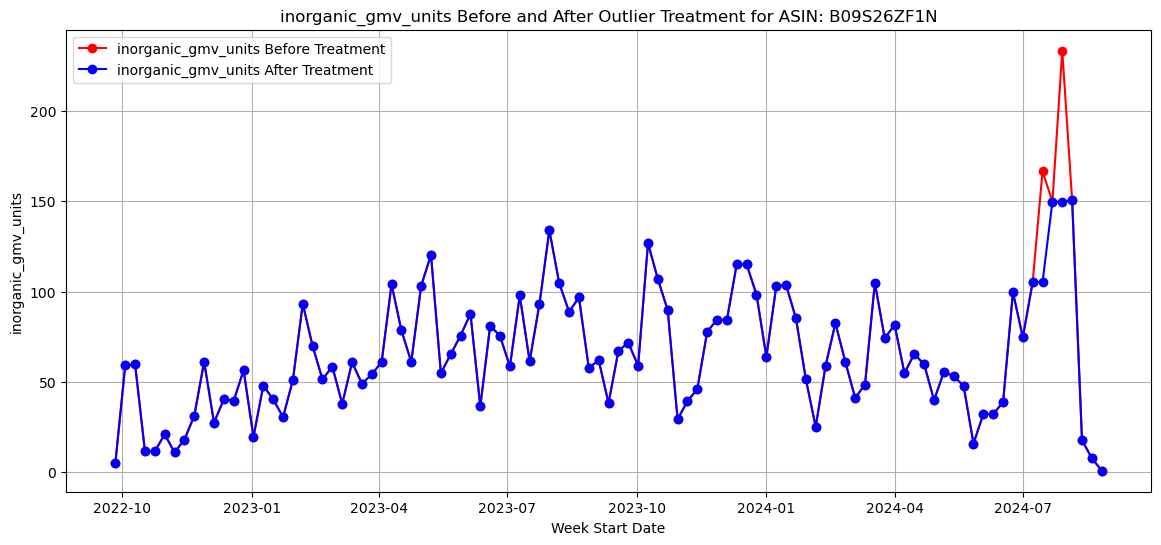

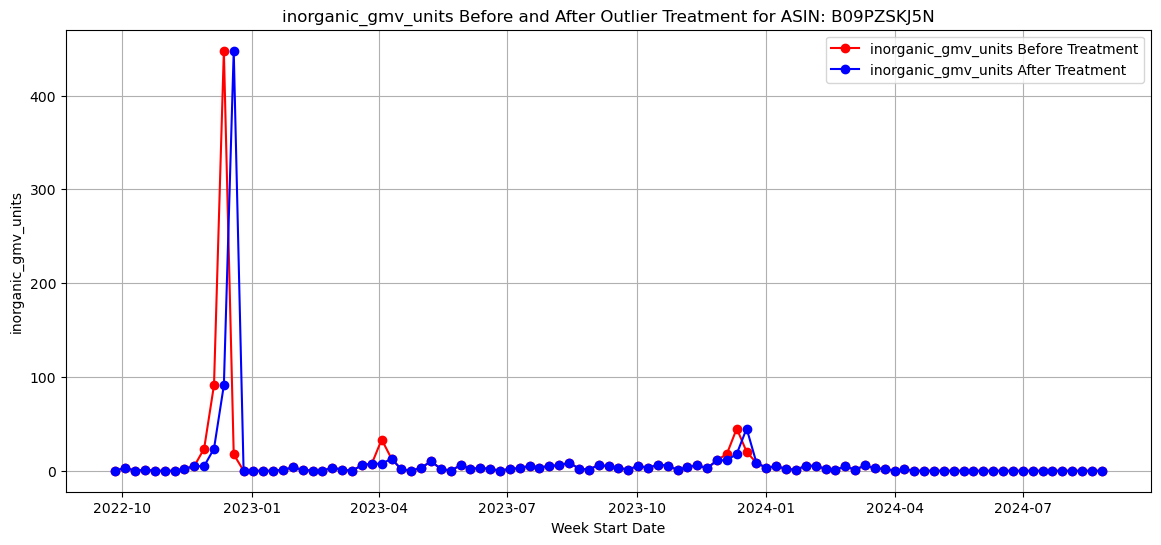

In [78]:
# Define the Outlier Treatment Function 
# Plotting Before and After Outlier Treatment

# Store original DataFrame before treatment
df_weekly_original = df_weekly.copy()

# Define the Outlier Treatment Function
def replace_outliers_with_previous_week(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Replace outliers with the previous week's value
    group[column] = np.where(outliers, group[column].shift(1), group[column])
    
    # In case the first value is an outlier and has no previous week to reference, we can forward fill
    group[column] = group[column].fillna(method='ffill')
    
    return group

# Apply the Outlier Treatment
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'organic_gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'inorganic_gmv_units').reset_index(drop=True)

# Plotting Before and After Outlier Treatment
def plot_outlier_treatment(df_before, df_after, column, asin_list):
    for asin in asin_list:
        df_before_asin = df_before[df_before['asin'] == asin]
        df_after_asin = df_after[df_after['asin'] == asin]
        
        plt.figure(figsize=(14, 6))
        plt.plot(df_before_asin['Week_Start_date'], df_before_asin[column], marker='o', color='red', label=f'{column} Before Treatment')
        plt.plot(df_after_asin['Week_Start_date'], df_after_asin[column], marker='o', color='blue', label=f'{column} After Treatment')
        plt.title(f"{column} Before and After Outlier Treatment for ASIN: {asin}")
        plt.xlabel("Week Start Date")
        plt.ylabel(column)
        plt.legend()
        plt.grid(True)
        plt.show()

# Use the actual list of ASINs you want to plot
asin_to_plot = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']
plot_outlier_treatment(df_weekly_original, df_weekly, 'gmv_units', asin_to_plot)
plot_outlier_treatment(df_weekly_original, df_weekly, 'organic_gmv_units', asin_to_plot)
plot_outlier_treatment(df_weekly_original, df_weekly, 'inorganic_gmv_units', asin_to_plot)


In [79]:
# Split the data into training and testing datasets
train_df = df_weekly[df_weekly['Week_Start_date'] <= '2024-04-29']
test_df = df_weekly[(df_weekly['Week_Start_date'] >= '2024-05-06') & (df_weekly['Week_Start_date'] <= '2024-08-19')]


In [80]:
train_df
test_df

,velocity_bucket,asin,Week_Start_date,Week_End_date,organic_gmv_units,inorganic_gmv_units,asp_week,ad_spend,inventory_Availability%,gmv,inorganic_gmv,organic_gmv,gmv_units,inventory_available
84,1_SF,B00PMR3QF2,2024-05-06,2024-05-12,2279.6918,944.2419,10.126884,12560.099224,116.666667,53388.93,29818.10,23087.56,1951.0,112692
85,1_SF,B00PMR3QF2,2024-05-13,2024-05-19,988.9535,775.0357,15.971567,4425.383745,116.666667,28333.56,12378.47,15795.19,1774.0,108699
86,1_SF,B00PMR3QF2,2024-05-20,2024-05-26,816.4571,272.9077,16.061609,1647.974694,100.000000,17667.77,4391.79,13104.90,1100.0,103875
87,1_SF,B00PMR3QF2,2024-05-27,2024-06-02,743.9493,480.7210,15.930057,3987.756753,100.000000,19625.83,7643.19,11865.61,1232.0,227322
88,1_SF,B00PMR3QF2,2024-06-03,2024-06-09,743.9493,480.7210,10.080928,9075.009429,100.000000,49729.22,23637.30,25673.50,1232.0,240204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29804,4_SM,B0D8HVYNM8,2024-07-22,2024-07-28,0.0000,0.0000,0.000000,0.000000,100.000000,0.00,0.00,0.00,0.0,3451
29805,4_SM,B0D8HVYNM8,2024-07-29,2024-08-04,0.0000,0.0000,0.000000,0.000000,116.666667,0.00,0.00,0.00,0.0,3427
29806,4_SM,B0D8HVYNM8,2024-08-05,2024-08-11,0.0000,0.0000,0.000000,0.000000,100.000000,0.00,0.00,0.00,0.0,3451
29807,4_SM,B0D8HVYNM8,2024-08-12,2024-08-18,0.0000,0.0000,0.000000,0.000000,100.000000,0.00,0.00,0.00,0.0,3451


In [81]:
# Ensure 'asin' column exists
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)


Columns in train_df: Index(['velocity_bucket', 'asin', 'Week_Start_date', 'Week_End_date',
       'organic_gmv_units', 'inorganic_gmv_units', 'asp_week', 'ad_spend',
       'inventory_Availability%', 'gmv', 'inorganic_gmv', 'organic_gmv',
       'gmv_units', 'inventory_available'],
      dtype='object')
Columns in test_df: Index(['velocity_bucket', 'asin', 'Week_Start_date', 'Week_End_date',
       'organic_gmv_units', 'inorganic_gmv_units', 'asp_week', 'ad_spend',
       'inventory_Availability%', 'gmv', 'inorganic_gmv', 'organic_gmv',
       'gmv_units', 'inventory_available'],
      dtype='object')


In [124]:
#version 2:
# GMV_units forecasting

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

# Define exogenous variables
exogenous_vars = ['asp_week', 'ad_spend']  # Adjust this to match your DataFrame column names

# Prepare dictionaries to store results
X_train_fb2 = {}
X_test_fb2 = {}
y_test_fb_pred2 = {}


for asin in train_df['asin'].unique():
    print(f"Processing ASIN: {asin}")
    
    # Filter the training data for the current ASIN
    asin_train_data = train_df[train_df['asin'] == asin]
    asin_test_data = test_df[test_df['asin'] == asin]
    
    if asin_train_data.empty or asin_test_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    
    # Prepare the training data for Prophet
    X_train_fb2[asin] = pd.DataFrame()
    X_train_fb2[asin]['ds'] = asin_train_data['Week_Start_date']
    X_train_fb2[asin]['y'] = asin_train_data['gmv_units']
    
    # Add exogenous variables
    X_train_fb2[asin][exogenous_vars] = asin_train_data[exogenous_vars]
    
    # Ensure data types are correct
    X_train_fb2[asin]['ds'] = pd.to_datetime(X_train_fb2[asin]['ds'])
    X_train_fb2[asin]['y'] = X_train_fb2[asin]['y'].astype(float)
    
    # Initialize the Prophet model
    model = Prophet(changepoint_prior_scale=0.03)
    
    # Prophet(interval_width=0.95, yearly_seasonality='auto', weekly_seasonality='auto',changepoint_prior_scale=0.03)
    
    # Add exogenous variables as regressors
    for var in exogenous_vars:
        model.add_regressor(var)
    
    # Fit the model
    try:
        model.fit(X_train_fb2[asin])
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        continue
    
    # Prepare the test data for Prophet
    X_test_fb2[asin] = pd.DataFrame()
    X_test_fb2[asin]['ds'] = asin_test_data['Week_Start_date']
    X_test_fb2[asin][exogenous_vars] = asin_test_data[exogenous_vars]
    
    # Ensure test data type is correct
    X_test_fb2[asin]['ds'] = pd.to_datetime(X_test_fb2[asin]['ds'])
    
    # Make predictions
    try:
        forecast_train = model.predict(X_train_fb2[asin].drop(columns=['y']))
        forecast_test = model.predict(X_test_fb2[asin])
    except ValueError as e:
        print(f"Error generating forecast for ASIN {asin}: {e}")
        continue
    
    # Store the predictions
    y_test_fb_pred2[asin] = forecast_test['yhat'].values
    y_test_fb_pred2[asin][y_test_fb_pred2[asin]<0] = 0
    y_test_fb_pred2[asin] = y_test_fb_pred2[asin].round(0).astype('int64')
    
# Create DataFrame with actual and forecasted values
df_results = []
for asin in y_test_fb_pred2:
    asin_test_data = test_df[test_df['asin'] == asin]
    df_results.append(pd.DataFrame({
        'asin': asin,
        'Week_Start_date': asin_test_data['Week_Start_date'],
        'actual_outlier_treated': asin_test_data['gmv_units'],
        'forecasted_value': y_test_fb_pred2[asin]
    }))

df_results = pd.concat(df_results, ignore_index=True)
    


Processing ASIN: B00PMR3QF2


00:44:53 - cmdstanpy - INFO - Chain [1] start processing
00:44:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00PV15BPW


00:44:53 - cmdstanpy - INFO - Chain [1] start processing
00:44:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00Q7Z1UZ6
No data found for ASIN: B00Q7Z1UZ6
Processing ASIN: B00Q96XGUU


00:44:54 - cmdstanpy - INFO - Chain [1] start processing
00:44:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR6SS6O


00:44:55 - cmdstanpy - INFO - Chain [1] start processing
00:44:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR7FTLU


00:44:55 - cmdstanpy - INFO - Chain [1] start processing
00:44:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR7T8WQ
No data found for ASIN: B00QR7T8WQ
Processing ASIN: B00QVR0O6Q


00:44:56 - cmdstanpy - INFO - Chain [1] start processing
00:44:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00STVN68K


00:44:57 - cmdstanpy - INFO - Chain [1] start processing
00:44:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00TSTZQEY


00:44:57 - cmdstanpy - INFO - Chain [1] start processing
00:44:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00UA2A0XK
No data found for ASIN: B00UA2A0XK
Processing ASIN: B00UREAGU8


00:44:58 - cmdstanpy - INFO - Chain [1] start processing
00:44:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VUNFLM8


00:44:59 - cmdstanpy - INFO - Chain [1] start processing
00:44:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VXEQ0WO
No data found for ASIN: B00VXEQ0WO
Processing ASIN: B00VXHY6KY
Processing ASIN: B00VXIV1XI
No data found for ASIN: B00VXIV1XI
Processing ASIN: B00WFXNXVI
No data found for ASIN: B00WFXNXVI
Processing ASIN: B00WH2CKCA
No data found for ASIN: B00WH2CKCA
Processing ASIN: B00WKTKBTY
No data found for ASIN: B00WKTKBTY
Processing ASIN: B00X4YGPYE


00:45:00 - cmdstanpy - INFO - Chain [1] start processing
00:45:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00XE58NJ8


00:45:01 - cmdstanpy - INFO - Chain [1] start processing
00:45:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00YQ93VPW
No data found for ASIN: B00YQ93VPW
Processing ASIN: B00Z5WJIHO
No data found for ASIN: B00Z5WJIHO
Processing ASIN: B01057FM6E
No data found for ASIN: B01057FM6E
Processing ASIN: B0105POI9I
No data found for ASIN: B0105POI9I
Processing ASIN: B011NSRBY0
No data found for ASIN: B011NSRBY0
Processing ASIN: B012UQJNMC
No data found for ASIN: B012UQJNMC
Processing ASIN: B014JFT9DU
No data found for ASIN: B014JFT9DU
Processing ASIN: B016H8ICBC
No data found for ASIN: B016H8ICBC
Processing ASIN: B016RQ8PRU
No data found for ASIN: B016RQ8PRU
Processing ASIN: B01728CU8M
No data found for ASIN: B01728CU8M
Processing ASIN: B0172AL2PM


00:45:01 - cmdstanpy - INFO - Chain [1] start processing
00:45:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01745E4C8
No data found for ASIN: B01745E4C8
Processing ASIN: B01766QDTC
No data found for ASIN: B01766QDTC
Processing ASIN: B01767OTVK


00:45:02 - cmdstanpy - INFO - Chain [1] start processing
00:45:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01768QEPI
No data found for ASIN: B01768QEPI
Processing ASIN: B0176OGWFE
Processing ASIN: B0176UQBJU


00:45:03 - cmdstanpy - INFO - Chain [1] start processing
00:45:03 - cmdstanpy - INFO - Chain [1] done processing
00:45:03 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0176YOIEQ


00:45:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01771C9H6
No data found for ASIN: B01771C9H6
Processing ASIN: B0177J3BVG
No data found for ASIN: B0177J3BVG
Processing ASIN: B017I2B8NK


00:45:04 - cmdstanpy - INFO - Chain [1] start processing
00:45:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B017SLT8ME
No data found for ASIN: B017SLT8ME
Processing ASIN: B01BGIB81Y
No data found for ASIN: B01BGIB81Y
Processing ASIN: B01BHO79V0
No data found for ASIN: B01BHO79V0
Processing ASIN: B01BHQ69S2


00:45:05 - cmdstanpy - INFO - Chain [1] start processing
00:45:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKALLBU


00:45:05 - cmdstanpy - INFO - Chain [1] start processing
00:45:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKB3C98


00:45:06 - cmdstanpy - INFO - Chain [1] start processing
00:45:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01CHW4QOO
No data found for ASIN: B01CHW4QOO
Processing ASIN: B01CKBJQCO
No data found for ASIN: B01CKBJQCO
Processing ASIN: B01CO4EPQY
No data found for ASIN: B01CO4EPQY
Processing ASIN: B01DV9H7Z2
No data found for ASIN: B01DV9H7Z2
Processing ASIN: B01DVU2ZQW
No data found for ASIN: B01DVU2ZQW
Processing ASIN: B01DXRVQ3Q


00:45:06 - cmdstanpy - INFO - Chain [1] start processing
00:45:07 - cmdstanpy - INFO - Chain [1] done processing
00:45:07 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B01ERVKA3Y
No data found for ASIN: B01ERVKA3Y
Processing ASIN: B01FR1PYXE
No data found for ASIN: B01FR1PYXE
Processing ASIN: B01FZRK3WW


00:45:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01G2R8NQC
Processing ASIN: B01GHF9OXU
No data found for ASIN: B01GHF9OXU
Processing ASIN: B01GZ6ZAVG
No data found for ASIN: B01GZ6ZAVG
Processing ASIN: B01HCWXUIC
No data found for ASIN: B01HCWXUIC
Processing ASIN: B01HIW5BG0
No data found for ASIN: B01HIW5BG0
Processing ASIN: B01HN30YAW
No data found for ASIN: B01HN30YAW
Processing ASIN: B01HSHKNC2
No data found for ASIN: B01HSHKNC2
Processing ASIN: B01HSM2M6W


00:45:08 - cmdstanpy - INFO - Chain [1] start processing
00:45:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IIJI4TS
No data found for ASIN: B01IIJI4TS
Processing ASIN: B01INZE248
No data found for ASIN: B01INZE248
Processing ASIN: B01IRKTYII


00:45:09 - cmdstanpy - INFO - Chain [1] start processing
00:45:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IRLOTNM


00:45:09 - cmdstanpy - INFO - Chain [1] start processing
00:45:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IU1ZUNM
No data found for ASIN: B01IU1ZUNM
Processing ASIN: B01JLJGIEC
No data found for ASIN: B01JLJGIEC
Processing ASIN: B01JRV494K
No data found for ASIN: B01JRV494K
Processing ASIN: B01JRW3EJA
No data found for ASIN: B01JRW3EJA
Processing ASIN: B01K2JRGXC


00:45:10 - cmdstanpy - INFO - Chain [1] start processing
00:45:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K86X4HG
No data found for ASIN: B01K86X4HG
Processing ASIN: B01K8IJVWG
No data found for ASIN: B01K8IJVWG
Processing ASIN: B01K8PEZMU


00:45:11 - cmdstanpy - INFO - Chain [1] start processing
00:45:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K8XC1FU
No data found for ASIN: B01K8XC1FU
Processing ASIN: B01K90KCP8
No data found for ASIN: B01K90KCP8
Processing ASIN: B01K91YRTO
No data found for ASIN: B01K91YRTO
Processing ASIN: B01K93HIDO
No data found for ASIN: B01K93HIDO
Processing ASIN: B01KFENEXK
No data found for ASIN: B01KFENEXK
Processing ASIN: B01KW4Q6VU
No data found for ASIN: B01KW4Q6VU
Processing ASIN: B01KYFMHJC
No data found for ASIN: B01KYFMHJC
Processing ASIN: B01LAHAQ2I
No data found for ASIN: B01LAHAQ2I
Processing ASIN: B01LAJP9LE
No data found for ASIN: B01LAJP9LE
Processing ASIN: B01LDGNJHK
No data found for ASIN: B01LDGNJHK
Processing ASIN: B01LMJQ53I
No data found for ASIN: B01LMJQ53I
Processing ASIN: B01LW1N3YN
No data found for ASIN: B01LW1N3YN
Processing ASIN: B01LWMTMIW
No data found for ASIN: B01LWMTMIW
Processing ASIN: B01LWYNWIF
No data found for ASIN: B01LWYNWIF
Processing ASIN: B01LWYU1NT


00:45:12 - cmdstanpy - INFO - Chain [1] start processing
00:45:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LWYV0F3
No data found for ASIN: B01LWYV0F3
Processing ASIN: B01LX9IIDJ


00:45:12 - cmdstanpy - INFO - Chain [1] start processing
00:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXALVDG


00:45:13 - cmdstanpy - INFO - Chain [1] start processing
00:45:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXMPA35
No data found for ASIN: B01LXMPA35
Processing ASIN: B01LXY3G5B
No data found for ASIN: B01LXY3G5B
Processing ASIN: B01LY9DCZ9
No data found for ASIN: B01LY9DCZ9
Processing ASIN: B01LY9FZHH
No data found for ASIN: B01LY9FZHH
Processing ASIN: B01LY9GFBF
No data found for ASIN: B01LY9GFBF
Processing ASIN: B01LYKQRWH
No data found for ASIN: B01LYKQRWH
Processing ASIN: B01LYR2KTP
No data found for ASIN: B01LYR2KTP
Processing ASIN: B01LZXGBZR


00:45:14 - cmdstanpy - INFO - Chain [1] start processing
00:45:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M07JVC2


00:45:14 - cmdstanpy - INFO - Chain [1] start processing
00:45:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M12V5G3
No data found for ASIN: B01M12V5G3
Processing ASIN: B01M1CJSZH
No data found for ASIN: B01M1CJSZH
Processing ASIN: B01MQYUZ0C
No data found for ASIN: B01MQYUZ0C
Processing ASIN: B01MSEKDFX
No data found for ASIN: B01MSEKDFX
Processing ASIN: B01MU29C2X
No data found for ASIN: B01MU29C2X
Processing ASIN: B01MUCO6ZU


00:45:15 - cmdstanpy - INFO - Chain [1] start processing
00:45:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01MY4KYSG
No data found for ASIN: B01MY4KYSG
Processing ASIN: B01MYA4Q1X
No data found for ASIN: B01MYA4Q1X
Processing ASIN: B01N1856R7


00:45:16 - cmdstanpy - INFO - Chain [1] start processing
00:45:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N2W16I8
No data found for ASIN: B01N2W16I8
Processing ASIN: B01N35XMUC
No data found for ASIN: B01N35XMUC
Processing ASIN: B01N3T69R3
No data found for ASIN: B01N3T69R3
Processing ASIN: B01N6IHDIN
No data found for ASIN: B01N6IHDIN
Processing ASIN: B01N6N716A
No data found for ASIN: B01N6N716A
Processing ASIN: B01N7L0WA6
No data found for ASIN: B01N7L0WA6
Processing ASIN: B01N7OJUIT
No data found for ASIN: B01N7OJUIT
Processing ASIN: B01N7U6R1F


00:45:17 - cmdstanpy - INFO - Chain [1] start processing
00:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N9EI165
No data found for ASIN: B01N9EI165
Processing ASIN: B01N9TLIJU
No data found for ASIN: B01N9TLIJU
Processing ASIN: B06XBSBTMV
No data found for ASIN: B06XBSBTMV
Processing ASIN: B06XC5D97Z
No data found for ASIN: B06XC5D97Z
Processing ASIN: B06XCCVDH7


00:45:17 - cmdstanpy - INFO - Chain [1] start processing
00:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06XDNKH65


00:45:18 - cmdstanpy - INFO - Chain [1] start processing
00:45:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06Y15C6CS
No data found for ASIN: B06Y15C6CS
Processing ASIN: B06ZZXG2CJ
No data found for ASIN: B06ZZXG2CJ
Processing ASIN: B071JCL3XQ
No data found for ASIN: B071JCL3XQ
Processing ASIN: B072YVYQVR
No data found for ASIN: B072YVYQVR
Processing ASIN: B0732HBHQX
Processing ASIN: B073XXQMM9
No data found for ASIN: B073XXQMM9
Processing ASIN: B074WZJDLZ
No data found for ASIN: B074WZJDLZ
Processing ASIN: B0753LHJ8X
No data found for ASIN: B0753LHJ8X
Processing ASIN: B075DJ88X5
No data found for ASIN: B075DJ88X5
Processing ASIN: B075KWWVR6


00:45:19 - cmdstanpy - INFO - Chain [1] start processing
00:45:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B075MSCQZJ
No data found for ASIN: B075MSCQZJ
Processing ASIN: B076YPNBBR
No data found for ASIN: B076YPNBBR
Processing ASIN: B076YQ62CH


00:45:19 - cmdstanpy - INFO - Chain [1] start processing
00:45:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B077GP9C96
No data found for ASIN: B077GP9C96
Processing ASIN: B077GPTZTS
No data found for ASIN: B077GPTZTS
Processing ASIN: B077KDFFL1
Processing ASIN: B078SS67K7
No data found for ASIN: B078SS67K7
Processing ASIN: B078W5K1T1
No data found for ASIN: B078W5K1T1
Processing ASIN: B079ZN8SC9


00:45:20 - cmdstanpy - INFO - Chain [1] start processing
00:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07BDQ2413


00:45:21 - cmdstanpy - INFO - Chain [1] start processing
00:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07C39LV4Z
No data found for ASIN: B07C39LV4Z
Processing ASIN: B07C5B9C16
No data found for ASIN: B07C5B9C16
Processing ASIN: B07CP15TC6


00:45:22 - cmdstanpy - INFO - Chain [1] start processing
00:45:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07CP3X2K3
No data found for ASIN: B07CP3X2K3
Processing ASIN: B07DJYGCHC
No data found for ASIN: B07DJYGCHC
Processing ASIN: B07DPWB7LW
No data found for ASIN: B07DPWB7LW
Processing ASIN: B07DX6RZ7G
Processing ASIN: B07F1FL4DF
Processing ASIN: B07F7G3PJW
No data found for ASIN: B07F7G3PJW
Processing ASIN: B07F7HCD73
Processing ASIN: B07G2M6FHP


00:45:23 - cmdstanpy - INFO - Chain [1] start processing
00:45:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G3MBG8C
Processing ASIN: B07G3MKDG7
Processing ASIN: B07G4LZDJH
No data found for ASIN: B07G4LZDJH
Processing ASIN: B07G7J87P3


00:45:25 - cmdstanpy - INFO - Chain [1] start processing
00:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G7LPY5C
No data found for ASIN: B07G7LPY5C
Processing ASIN: B07G7LTQ9Q
No data found for ASIN: B07G7LTQ9Q
Processing ASIN: B07G7QVSZT


00:45:25 - cmdstanpy - INFO - Chain [1] start processing
00:45:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8J8F3Z
No data found for ASIN: B07G8J8F3Z
Processing ASIN: B07G8JN3NF
No data found for ASIN: B07G8JN3NF
Processing ASIN: B07G8JTRDX
No data found for ASIN: B07G8JTRDX
Processing ASIN: B07G8K7VT1
No data found for ASIN: B07G8K7VT1
Processing ASIN: B07G8KG4S7
Processing ASIN: B07G8LV6PV
No data found for ASIN: B07G8LV6PV
Processing ASIN: B07G8LV7KX


00:45:26 - cmdstanpy - INFO - Chain [1] start processing
00:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8LY9HB
No data found for ASIN: B07G8LY9HB
Processing ASIN: B07G8M3DTX


00:45:27 - cmdstanpy - INFO - Chain [1] start processing
00:45:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8M4M46
Processing ASIN: B07G8MDG19


00:45:28 - cmdstanpy - INFO - Chain [1] start processing
00:45:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8MHVXQ
No data found for ASIN: B07G8MHVXQ
Processing ASIN: B07G8MK45Z
No data found for ASIN: B07G8MK45Z
Processing ASIN: B07G8MPT3N
No data found for ASIN: B07G8MPT3N
Processing ASIN: B07G8N5ZP4
No data found for ASIN: B07G8N5ZP4
Processing ASIN: B07G8NDRF7


00:45:28 - cmdstanpy - INFO - Chain [1] start processing
00:45:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8P6NMW
No data found for ASIN: B07G8P6NMW
Processing ASIN: B07G8Q4WG2


00:45:29 - cmdstanpy - INFO - Chain [1] start processing
00:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8QZ4DY


00:45:30 - cmdstanpy - INFO - Chain [1] start processing
00:45:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GHC8QB5


00:45:31 - cmdstanpy - INFO - Chain [1] start processing
00:45:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GJ7P4DQ
No data found for ASIN: B07GJ7P4DQ
Processing ASIN: B07GNZP9P5
No data found for ASIN: B07GNZP9P5
Processing ASIN: B07GPDRXDF
Processing ASIN: B07GPHG3L7


00:45:32 - cmdstanpy - INFO - Chain [1] start processing
00:45:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPK352D


00:45:32 - cmdstanpy - INFO - Chain [1] start processing
00:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPM6Q4Q


00:45:33 - cmdstanpy - INFO - Chain [1] start processing
00:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPNQZSG


00:45:33 - cmdstanpy - INFO - Chain [1] start processing
00:45:34 - cmdstanpy - INFO - Chain [1] done processing
00:45:34 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07GPS2MCV


00:45:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPWVC4F
No data found for ASIN: B07GPWVC4F
Processing ASIN: B07GPWX8CF
No data found for ASIN: B07GPWX8CF
Processing ASIN: B07GPXSBDW


00:45:35 - cmdstanpy - INFO - Chain [1] start processing
00:45:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GQ4N8KR


00:45:35 - cmdstanpy - INFO - Chain [1] start processing
00:45:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07H8JL7MV
No data found for ASIN: B07H8JL7MV
Processing ASIN: B07H8KP1PB
No data found for ASIN: B07H8KP1PB
Processing ASIN: B07HFFGFWD


00:45:36 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07HFFMY2X


00:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HGG6VX4


00:45:37 - cmdstanpy - INFO - Chain [1] start processing
00:45:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HPFYQLB
No data found for ASIN: B07HPFYQLB
Processing ASIN: B07HQ4Q4GY


00:45:38 - cmdstanpy - INFO - Chain [1] start processing
00:45:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HQ4YBSS
No data found for ASIN: B07HQ4YBSS
Processing ASIN: B07HQGK7L4
No data found for ASIN: B07HQGK7L4
Processing ASIN: B07HRCY6ND
Processing ASIN: B07J2BTN19


00:45:39 - cmdstanpy - INFO - Chain [1] start processing
00:45:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07JD9FS28


00:45:39 - cmdstanpy - INFO - Chain [1] start processing
00:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC2R52N


00:45:40 - cmdstanpy - INFO - Chain [1] start processing
00:45:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC39RQ2


00:45:40 - cmdstanpy - INFO - Chain [1] start processing
00:45:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC44XSS


00:45:41 - cmdstanpy - INFO - Chain [1] start processing
00:45:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LD3HRX5


00:45:42 - cmdstanpy - INFO - Chain [1] start processing
00:45:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07M6TF42M


00:45:43 - cmdstanpy - INFO - Chain [1] start processing
00:45:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2GRLKB
No data found for ASIN: B07N2GRLKB
Processing ASIN: B07N2GXFVK


00:45:43 - cmdstanpy - INFO - Chain [1] start processing
00:45:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2LSXR9
No data found for ASIN: B07N2LSXR9
Processing ASIN: B07NCXHRZ7
Processing ASIN: B07NF9S9FT
Processing ASIN: B07NQSTXL1


00:45:44 - cmdstanpy - INFO - Chain [1] start processing
00:45:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NS43346


00:45:45 - cmdstanpy - INFO - Chain [1] start processing
00:45:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NS6C8Y9


00:45:46 - cmdstanpy - INFO - Chain [1] start processing
00:45:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NSF3K1Y


00:45:47 - cmdstanpy - INFO - Chain [1] start processing
00:45:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NY3P5B3
Processing ASIN: B07P3WRN9L


00:45:48 - cmdstanpy - INFO - Chain [1] start processing
00:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07P528MHM


00:45:48 - cmdstanpy - INFO - Chain [1] start processing
00:45:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PNRNWBM
Processing ASIN: B07PPJLSRW


00:45:49 - cmdstanpy - INFO - Chain [1] start processing
00:45:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PPWQX7X


00:45:50 - cmdstanpy - INFO - Chain [1] start processing
00:45:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PQWXW5B


00:45:51 - cmdstanpy - INFO - Chain [1] start processing
00:45:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PRDSY6J


00:45:51 - cmdstanpy - INFO - Chain [1] start processing
00:45:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07QXV6T4K
Processing ASIN: B07R27WXXB


00:45:53 - cmdstanpy - INFO - Chain [1] start processing
00:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R39354D


00:45:53 - cmdstanpy - INFO - Chain [1] start processing
00:45:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R56QYWH


00:45:54 - cmdstanpy - INFO - Chain [1] start processing
00:45:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07RM9DR6C


00:45:54 - cmdstanpy - INFO - Chain [1] start processing
00:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07SC59HR7
Processing ASIN: B07SGCBRZX
No data found for ASIN: B07SGCBRZX
Processing ASIN: B07SQHFP52
No data found for ASIN: B07SQHFP52
Processing ASIN: B07TKD35BH
No data found for ASIN: B07TKD35BH
Processing ASIN: B07TKZRNGZ
No data found for ASIN: B07TKZRNGZ
Processing ASIN: B07TL82G4B


00:45:55 - cmdstanpy - INFO - Chain [1] start processing
00:45:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07VXK2RX4
Processing ASIN: B07WS32W25
Processing ASIN: B07WT7MQ6C


00:45:57 - cmdstanpy - INFO - Chain [1] start processing
00:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XHNP8FC


00:45:57 - cmdstanpy - INFO - Chain [1] start processing
00:45:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XKBVRXW
Processing ASIN: B07XSN63KL


00:45:58 - cmdstanpy - INFO - Chain [1] start processing
00:45:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07Y29JGSK


00:45:59 - cmdstanpy - INFO - Chain [1] start processing
00:45:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07ZJT647G


00:45:59 - cmdstanpy - INFO - Chain [1] start processing
00:46:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B081C84KCS


00:46:00 - cmdstanpy - INFO - Chain [1] start processing
00:46:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082BG9JJC


00:46:01 - cmdstanpy - INFO - Chain [1] start processing
00:46:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082PH769D


00:46:01 - cmdstanpy - INFO - Chain [1] start processing
00:46:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TLTQGB


00:46:02 - cmdstanpy - INFO - Chain [1] start processing
00:46:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TW3YFH
No data found for ASIN: B082TW3YFH
Processing ASIN: B082XJ6HRF


00:46:03 - cmdstanpy - INFO - Chain [1] start processing
00:46:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F4KNSV


00:46:03 - cmdstanpy - INFO - Chain [1] start processing
00:46:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F6JJ2Q


00:46:04 - cmdstanpy - INFO - Chain [1] start processing
00:46:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B084HPS72C
Processing ASIN: B084RYWVLV


00:46:05 - cmdstanpy - INFO - Chain [1] start processing
00:46:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0859M79CD


00:46:05 - cmdstanpy - INFO - Chain [1] start processing
00:46:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085KS85KX


00:46:06 - cmdstanpy - INFO - Chain [1] start processing
00:46:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085KW8Z1S


00:46:07 - cmdstanpy - INFO - Chain [1] start processing
00:46:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085P3BFKV
Processing ASIN: B085WZ5187


00:46:08 - cmdstanpy - INFO - Chain [1] start processing
00:46:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0861DW1YC
No data found for ASIN: B0861DW1YC
Processing ASIN: B08682PYNV
No data found for ASIN: B08682PYNV
Processing ASIN: B086GFZBKZ
No data found for ASIN: B086GFZBKZ
Processing ASIN: B0871MYG6R


00:46:08 - cmdstanpy - INFO - Chain [1] start processing
00:46:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B088PBW37Q


00:46:09 - cmdstanpy - INFO - Chain [1] start processing
00:46:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08B85MWMX


00:46:10 - cmdstanpy - INFO - Chain [1] start processing
00:46:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08B89NVSH
No data found for ASIN: B08B89NVSH
Processing ASIN: B08BDBZMXV


00:46:10 - cmdstanpy - INFO - Chain [1] start processing
00:46:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BG67576


00:46:11 - cmdstanpy - INFO - Chain [1] start processing
00:46:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BWL3SMY
No data found for ASIN: B08BWL3SMY
Processing ASIN: B08D2HWV3K
Processing ASIN: B08DJXYRF1


00:46:12 - cmdstanpy - INFO - Chain [1] start processing
00:46:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08DK8CH4L
Processing ASIN: B08DKBBYXQ


00:46:13 - cmdstanpy - INFO - Chain [1] start processing
00:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HBRN53J
No data found for ASIN: B08HBRN53J
Processing ASIN: B08HNFNTJQ


00:46:32 - cmdstanpy - INFO - Chain [1] start processing
00:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HPS9NQ5


00:46:33 - cmdstanpy - INFO - Chain [1] start processing
00:46:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HR8HPPG
Processing ASIN: B08K3M16PR
No data found for ASIN: B08K3M16PR
Processing ASIN: B08K9CDH4Y


00:46:33 - cmdstanpy - INFO - Chain [1] start processing
00:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGHD5L9


00:46:34 - cmdstanpy - INFO - Chain [1] start processing
00:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGXZHFS
Processing ASIN: B08KHYTWKV
No data found for ASIN: B08KHYTWKV
Processing ASIN: B08KSFZXPB


00:46:35 - cmdstanpy - INFO - Chain [1] start processing
00:46:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KSLPPLD
Processing ASIN: B08KSMJ6TX
Processing ASIN: B08KTYDNTT
Processing ASIN: B08KWR1LTS
Processing ASIN: B08KWRJKHR
Processing ASIN: B08KWRYH5F
Processing ASIN: B08KWSNPBY
No data found for ASIN: B08KWSNPBY
Processing ASIN: B08KXPQ9SJ
No data found for ASIN: B08KXPQ9SJ
Processing ASIN: B08KXQH58T
No data found for ASIN: B08KXQH58T
Processing ASIN: B08KXVJQZV
No data found for ASIN: B08KXVJQZV
Processing ASIN: B08KXXVV5T
No data found for ASIN: B08KXXVV5T
Processing ASIN: B08L3XW7CW


00:46:37 - cmdstanpy - INFO - Chain [1] start processing
00:46:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L3Z6CW4


00:46:38 - cmdstanpy - INFO - Chain [1] start processing
00:46:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L3ZZFGB
No data found for ASIN: B08L3ZZFGB
Processing ASIN: B08L41RB8F


00:46:39 - cmdstanpy - INFO - Chain [1] start processing
00:46:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L43ZVXY
Processing ASIN: B08L5LBXTT
No data found for ASIN: B08L5LBXTT
Processing ASIN: B08L8G69LG
No data found for ASIN: B08L8G69LG
Processing ASIN: B08L8GTWFV


00:46:40 - cmdstanpy - INFO - Chain [1] start processing
00:46:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08PF7PTWC
Processing ASIN: B08QDKV99N


00:46:42 - cmdstanpy - INFO - Chain [1] start processing
00:46:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08QXB6H5P
No data found for ASIN: B08QXB6H5P
Processing ASIN: B08VW53HN6


00:46:42 - cmdstanpy - INFO - Chain [1] start processing
00:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08VWCZYZ6


00:46:43 - cmdstanpy - INFO - Chain [1] start processing
00:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS67HRW


00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS77TZX


00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS7DPH3


00:46:45 - cmdstanpy - INFO - Chain [1] start processing
00:46:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B091DKHXW4


00:46:46 - cmdstanpy - INFO - Chain [1] start processing
00:46:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B099CD48QT


00:46:46 - cmdstanpy - INFO - Chain [1] start processing
00:46:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09BP2F8GC


00:46:47 - cmdstanpy - INFO - Chain [1] start processing
00:46:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09C2MZ9DC


00:46:48 - cmdstanpy - INFO - Chain [1] start processing
00:46:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ4SSSM


00:46:48 - cmdstanpy - INFO - Chain [1] start processing
00:46:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ9Y4P1


00:46:49 - cmdstanpy - INFO - Chain [1] start processing
00:46:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DZ5BDMV


00:46:50 - cmdstanpy - INFO - Chain [1] start processing
00:46:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09F9YSS2L


00:46:50 - cmdstanpy - INFO - Chain [1] start processing
00:46:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09FNCBK5V
Processing ASIN: B09G3LJLLQ


00:46:51 - cmdstanpy - INFO - Chain [1] start processing
00:46:51 - cmdstanpy - INFO - Chain [1] done processing
00:46:52 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09G426QPY


00:46:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GTMY8B8


00:46:52 - cmdstanpy - INFO - Chain [1] start processing
00:46:53 - cmdstanpy - INFO - Chain [1] done processing
00:46:53 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09GTX381G


00:46:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GV1ZCSX


00:46:53 - cmdstanpy - INFO - Chain [1] start processing
00:46:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSMQJ99


00:46:54 - cmdstanpy - INFO - Chain [1] start processing
00:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQLT81


00:46:55 - cmdstanpy - INFO - Chain [1] start processing
00:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQQ8SY


00:46:56 - cmdstanpy - INFO - Chain [1] start processing
00:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL834PX


00:46:57 - cmdstanpy - INFO - Chain [1] start processing
00:46:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8BG45


00:46:57 - cmdstanpy - INFO - Chain [1] start processing
00:46:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V5BS


00:46:58 - cmdstanpy - INFO - Chain [1] start processing
00:46:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V6RB


00:46:59 - cmdstanpy - INFO - Chain [1] start processing
00:46:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JQWRK6C


00:47:00 - cmdstanpy - INFO - Chain [1] start processing
00:47:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR32H3M


00:47:00 - cmdstanpy - INFO - Chain [1] start processing
00:47:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR7JLGM


00:47:01 - cmdstanpy - INFO - Chain [1] start processing
00:47:01 - cmdstanpy - INFO - Chain [1] done processing
00:47:02 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09MDS5VQF


00:47:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09MDSZ164


00:47:02 - cmdstanpy - INFO - Chain [1] start processing
00:47:02 - cmdstanpy - INFO - Chain [1] done processing
00:47:03 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09N7Y78Q7


00:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09NF6XNP9


00:47:03 - cmdstanpy - INFO - Chain [1] start processing
00:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P1T6W7S


00:47:04 - cmdstanpy - INFO - Chain [1] start processing
00:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P25LZNV


00:47:05 - cmdstanpy - INFO - Chain [1] start processing
00:47:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PSQDWLV


00:47:06 - cmdstanpy - INFO - Chain [1] start processing
00:47:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZM9CTX


00:47:06 - cmdstanpy - INFO - Chain [1] start processing
00:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZPN7S5


00:47:07 - cmdstanpy - INFO - Chain [1] start processing
00:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZQNZPB


00:47:08 - cmdstanpy - INFO - Chain [1] start processing
00:47:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZSKJ5N


00:47:08 - cmdstanpy - INFO - Chain [1] start processing
00:47:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QMT3CVT


00:47:09 - cmdstanpy - INFO - Chain [1] start processing
00:47:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QNKBF6F


00:47:09 - cmdstanpy - INFO - Chain [1] start processing
00:47:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09RTHS8BH


00:47:10 - cmdstanpy - INFO - Chain [1] start processing
00:47:10 - cmdstanpy - INFO - Chain [1] done processing
00:47:11 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09RYRHYHH


00:47:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S1ZZ9CZ


00:47:11 - cmdstanpy - INFO - Chain [1] start processing
00:47:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S24PFJ3


00:47:12 - cmdstanpy - INFO - Chain [1] start processing
00:47:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S26ZF1N


00:47:12 - cmdstanpy - INFO - Chain [1] start processing
00:47:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S27HQ62


00:47:13 - cmdstanpy - INFO - Chain [1] start processing
00:47:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S28PGXD


00:47:14 - cmdstanpy - INFO - Chain [1] start processing
00:47:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2B9221


00:47:14 - cmdstanpy - INFO - Chain [1] start processing
00:47:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2DZHRQ


00:47:15 - cmdstanpy - INFO - Chain [1] start processing
00:47:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2FFR9X


00:47:16 - cmdstanpy - INFO - Chain [1] start processing
00:47:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2H6PPY


00:47:17 - cmdstanpy - INFO - Chain [1] start processing
00:47:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2JJK8J


00:47:17 - cmdstanpy - INFO - Chain [1] start processing
00:47:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09XQBVP4L


00:47:18 - cmdstanpy - INFO - Chain [1] start processing
00:47:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B8447M2N


00:47:19 - cmdstanpy - INFO - Chain [1] start processing
00:47:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86PTXC7


00:47:19 - cmdstanpy - INFO - Chain [1] start processing
00:47:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86Q98DP


00:47:20 - cmdstanpy - INFO - Chain [1] start processing
00:47:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915D55W


00:47:21 - cmdstanpy - INFO - Chain [1] start processing
00:47:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915KZW2


00:47:21 - cmdstanpy - INFO - Chain [1] start processing
00:47:21 - cmdstanpy - INFO - Chain [1] done processing
00:47:22 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0B9168ZLY


00:47:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916GSYF


00:47:23 - cmdstanpy - INFO - Chain [1] start processing
00:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916KFC1


00:47:23 - cmdstanpy - INFO - Chain [1] start processing
00:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916YK43


00:47:24 - cmdstanpy - INFO - Chain [1] start processing
00:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9172ZB1


00:47:24 - cmdstanpy - INFO - Chain [1] start processing
00:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917D3PT


00:47:25 - cmdstanpy - INFO - Chain [1] start processing
00:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917GVQB


00:47:26 - cmdstanpy - INFO - Chain [1] start processing
00:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917H54K


00:47:26 - cmdstanpy - INFO - Chain [1] start processing
00:47:27 - cmdstanpy - INFO - Chain [1] done processing
00:47:27 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0B917SHXV


00:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917T9P5


00:47:28 - cmdstanpy - INFO - Chain [1] start processing
00:47:28 - cmdstanpy - INFO - Chain [1] done processing
00:47:28 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0B9194J2B


00:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B919Q5RM


00:47:29 - cmdstanpy - INFO - Chain [1] start processing
00:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91LZ8L7


00:47:29 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91MG5X5


00:47:30 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH84XZY4


00:47:31 - cmdstanpy - INFO - Chain [1] start processing
00:47:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH8CBS8M


00:47:31 - cmdstanpy - INFO - Chain [1] start processing
00:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH8Q4YM6


00:47:32 - cmdstanpy - INFO - Chain [1] start processing
00:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFC2RR


00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFQG5T


00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z44JLK


00:47:34 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z5WTR6


00:47:34 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z8QT9V


00:47:35 - cmdstanpy - INFO - Chain [1] start processing
00:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C656HMKC


00:47:35 - cmdstanpy - INFO - Chain [1] start processing
00:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C656PN55


00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658712G


00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658PXB1


00:47:37 - cmdstanpy - INFO - Chain [1] start processing
00:47:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65C3TBL


00:47:38 - cmdstanpy - INFO - Chain [1] start processing
00:47:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65CP9PP


00:47:38 - cmdstanpy - INFO - Chain [1] start processing
00:47:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65CVJQG


00:47:39 - cmdstanpy - INFO - Chain [1] start processing
00:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65DB8C4


00:47:39 - cmdstanpy - INFO - Chain [1] start processing
00:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6XVFJPZ


00:47:40 - cmdstanpy - INFO - Chain [1] start processing
00:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y3RD2P


00:47:41 - cmdstanpy - INFO - Chain [1] start processing
00:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y478R5


00:47:41 - cmdstanpy - INFO - Chain [1] start processing
00:47:41 - cmdstanpy - INFO - Chain [1] done processing
00:47:42 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0CBVD9G2B


00:47:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CH313718


00:47:42 - cmdstanpy - INFO - Chain [1] start processing
00:47:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBBQXY6


00:47:43 - cmdstanpy - INFO - Chain [1] start processing
00:47:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBF8BXP


00:47:43 - cmdstanpy - INFO - Chain [1] start processing
00:47:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBMQHB6


00:47:44 - cmdstanpy - INFO - Chain [1] start processing
00:47:44 - cmdstanpy - INFO - Chain [1] done processing
00:47:44 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0CHBNK3ZD


00:47:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCBNBVX


00:47:45 - cmdstanpy - INFO - Chain [1] start processing
00:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCJJ328


00:47:45 - cmdstanpy - INFO - Chain [1] start processing
00:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCMS4M8


00:47:46 - cmdstanpy - INFO - Chain [1] start processing
00:47:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZ2HVL


00:47:46 - cmdstanpy - INFO - Chain [1] start processing
00:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZKY4Q


00:47:47 - cmdstanpy - INFO - Chain [1] start processing
00:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHG17WP9


00:47:48 - cmdstanpy - INFO - Chain [1] start processing
00:47:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJCNSDV


00:47:48 - cmdstanpy - INFO - Chain [1] start processing
00:47:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJGH6BJ


00:47:49 - cmdstanpy - INFO - Chain [1] start processing
00:47:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKBWC3DG


00:47:49 - cmdstanpy - INFO - Chain [1] start processing
00:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKF1WBRV


00:47:50 - cmdstanpy - INFO - Chain [1] start processing
00:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKVX37KH


00:47:50 - cmdstanpy - INFO - Chain [1] start processing
00:47:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKVXYN46
Processing ASIN: B0CKXTLXSX


00:47:53 - cmdstanpy - INFO - Chain [1] start processing
00:47:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVL174K


00:47:54 - cmdstanpy - INFO - Chain [1] start processing
00:47:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVLTSDC


00:47:54 - cmdstanpy - INFO - Chain [1] start processing
00:47:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CQH9FHZT


00:47:55 - cmdstanpy - INFO - Chain [1] start processing
00:47:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CQHC2L5J


00:47:56 - cmdstanpy - INFO - Chain [1] start processing
00:47:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CXDH2LPP
Processing ASIN: B0CXDHX2QN
Processing ASIN: B0CXDRY3WC
Processing ASIN: B0CXDSCVJB
Processing ASIN: B0D1XNW89X
Error fitting model for ASIN B0D1XNW89X: Dataframe has less than 2 non-NaN rows.
Processing ASIN: B0D4VHWB3C
Error fitting model for ASIN B0D4VHWB3C: Dataframe has less than 2 non-NaN rows.


In [125]:
# Storing Results in a DataFrame and Calculating Metrics:


df_base1 = df_base[['asin', 'Week_Start_date','gmv_units']]

df_results1 =  pd.merge(df_results, df_base1, left_on=['asin', 'Week_Start_date'],
                     right_on=['asin', 'Week_Start_date'])


df_results2 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_results1,left_on='asin', right_on='asin', how='right')

# Calculate Absolute Percentage Error
df_results2['absolute_percentage_error'] = abs((df_results2['forecasted_value'] - df_results2['gmv_units']) / df_results2['gmv_units'])

# Calculate Absolute Errors
df_results2['absolute_error'] = abs(df_results2['forecasted_value'] - df_results2['gmv_units'])

# Calculate overall WAPE
overall_wape = df_results2['absolute_error'].sum() / df_results2['gmv_units'].sum()
print(f"\nOverall WAPE: {overall_wape:.2%}")

# df_results2

# Calculate WAPE for each date and velocity bucket
wape_per_date = df_results2.groupby(['Week_Start_date']).apply(
    lambda x: x['absolute_error'].sum() / x['gmv_units'].sum()
).reset_index(name='WAPE')

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date)

# Save the forecast results to a CSV file
wape_per_date.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_GMV_units.csv', index=False)


# Calculate WAPE for each date and velocity bucket
wape_per_date_bucket = df_results2.groupby(['Week_Start_date', 'velocity_bucket']).apply(
    lambda x: x['absolute_error'].sum() / x['gmv_units'].sum()
).reset_index(name='WAPE')

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date_bucket)

# Save the forecast results to a CSV file
wape_per_date_bucket.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_buckets_GMV_units.csv', index=False)



Overall WAPE: 35.68%

WAPE for each forecast date:
   Week_Start_date      WAPE
0       2024-05-06  0.252929
1       2024-05-13  0.232231
2       2024-05-20  0.415953
3       2024-05-27  0.322987
4       2024-06-03  0.285898
5       2024-06-10  0.325447
6       2024-06-17  0.371930
7       2024-06-24  0.373366
8       2024-07-01  0.374497
9       2024-07-08  0.347142
10      2024-07-15  0.452095
11      2024-07-22  0.360471
12      2024-07-29  0.472087
13      2024-08-05  0.357636
14      2024-08-12  0.308583
15      2024-08-19  0.318529

WAPE for each forecast date:
   Week_Start_date velocity_bucket      WAPE
0       2024-05-06            1_SF  0.170955
1       2024-05-06             2_F  0.283995
2       2024-05-06             3_M  0.287376
3       2024-05-06            4_SM  0.307346
4       2024-05-13            1_SF  0.115844
..             ...             ...       ...
59      2024-08-12            4_SM  0.526214
60      2024-08-19            1_SF  0.163408
61      2024-08-19  

In [84]:
%%time

# Forecasting organic_gmv_units


import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

# Define exogenous variables
exogenous_vars = ['asp_week', 'ad_spend']  # Adjust this to match your DataFrame column names

# Prepare dictionaries to store results
X_train_fb2 = {}
X_test_fb2 = {}
y_test_fb_pred2 = {}

for asin in train_df['asin'].unique():
    print(f"Processing ASIN: {asin}")
    
    # Filter the training data for the current ASIN
    asin_train_data = train_df[train_df['asin'] == asin]
    asin_test_data = test_df[test_df['asin'] == asin]
    
    if asin_train_data.empty or asin_test_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    
    # Prepare the training data for Prophet
    X_train_fb2[asin] = pd.DataFrame()
    X_train_fb2[asin]['ds'] = asin_train_data['Week_Start_date']
    X_train_fb2[asin]['y'] = asin_train_data['organic_gmv_units']
    
    # Add exogenous variables
    X_train_fb2[asin][exogenous_vars] = asin_train_data[exogenous_vars]
    
    # Ensure data types are correct
    X_train_fb2[asin]['ds'] = pd.to_datetime(X_train_fb2[asin]['ds'])
    X_train_fb2[asin]['y'] = X_train_fb2[asin]['y'].astype(float)
    
    # Initialize the Prophet model
    model = Prophet(changepoint_prior_scale=0.03)
    
    # Add exogenous variables as regressors
    for var in exogenous_vars:
        model.add_regressor(var)
    
    # Fit the model
    try:
        model.fit(X_train_fb2[asin])
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        continue
    
    # Prepare the test data for Prophet
    X_test_fb2[asin] = pd.DataFrame()
    X_test_fb2[asin]['ds'] = asin_test_data['Week_Start_date']
    X_test_fb2[asin][exogenous_vars] = asin_test_data[exogenous_vars]
    
    # Ensure test data type is correct
    X_test_fb2[asin]['ds'] = pd.to_datetime(X_test_fb2[asin]['ds'])
    
    # Make predictions
    try:
        forecast_test = model.predict(X_test_fb2[asin])
    except ValueError as e:
        print(f"Error generating forecast for ASIN {asin}: {e}")
        continue
    
    # Store the predictions
    y_test_fb_pred2[asin] = forecast_test['yhat'].values
    y_test_fb_pred2[asin][y_test_fb_pred2[asin]<0] = 0
    y_test_fb_pred2[asin] = y_test_fb_pred2[asin].round(0).astype('int64')
    
# Create DataFrame with actual and forecasted values
df_results_org = []
for asin in y_test_fb_pred2:
    asin_test_data = test_df[test_df['asin'] == asin]
    df_results_org.append(pd.DataFrame({
        'asin': asin,
        'Week_Start_date': asin_test_data['Week_Start_date'],
        'org_actual_outlier_treated': asin_test_data['organic_gmv_units'],
        'forecasted_value': y_test_fb_pred2[asin]
    }))

df_results_org = pd.concat(df_results_org, ignore_index=True)



Processing ASIN: B00PMR3QF2


23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00PV15BPW


23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00Q7Z1UZ6
No data found for ASIN: B00Q7Z1UZ6
Processing ASIN: B00Q96XGUU


23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR6SS6O


23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR7FTLU


23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR7T8WQ
No data found for ASIN: B00QR7T8WQ
Processing ASIN: B00QVR0O6Q


23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00STVN68K


23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00TSTZQEY


23:39:37 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00UA2A0XK
No data found for ASIN: B00UA2A0XK
Processing ASIN: B00UREAGU8


23:39:38 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VUNFLM8


23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VXEQ0WO
No data found for ASIN: B00VXEQ0WO
Processing ASIN: B00VXHY6KY
Processing ASIN: B00VXIV1XI
No data found for ASIN: B00VXIV1XI
Processing ASIN: B00WFXNXVI
No data found for ASIN: B00WFXNXVI
Processing ASIN: B00WH2CKCA
No data found for ASIN: B00WH2CKCA
Processing ASIN: B00WKTKBTY
No data found for ASIN: B00WKTKBTY
Processing ASIN: B00X4YGPYE


23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00XE58NJ8


23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00YQ93VPW
No data found for ASIN: B00YQ93VPW
Processing ASIN: B00Z5WJIHO
No data found for ASIN: B00Z5WJIHO
Processing ASIN: B01057FM6E
No data found for ASIN: B01057FM6E
Processing ASIN: B0105POI9I
No data found for ASIN: B0105POI9I
Processing ASIN: B011NSRBY0
No data found for ASIN: B011NSRBY0
Processing ASIN: B012UQJNMC
No data found for ASIN: B012UQJNMC
Processing ASIN: B014JFT9DU
No data found for ASIN: B014JFT9DU
Processing ASIN: B016H8ICBC
No data found for ASIN: B016H8ICBC
Processing ASIN: B016RQ8PRU
No data found for ASIN: B016RQ8PRU
Processing ASIN: B01728CU8M
No data found for ASIN: B01728CU8M
Processing ASIN: B0172AL2PM


23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01745E4C8
No data found for ASIN: B01745E4C8
Processing ASIN: B01766QDTC
No data found for ASIN: B01766QDTC
Processing ASIN: B01767OTVK


23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01768QEPI
No data found for ASIN: B01768QEPI
Processing ASIN: B0176OGWFE
Processing ASIN: B0176UQBJU


23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0176YOIEQ


23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01771C9H6
No data found for ASIN: B01771C9H6
Processing ASIN: B0177J3BVG
No data found for ASIN: B0177J3BVG
Processing ASIN: B017I2B8NK


23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B017SLT8ME
No data found for ASIN: B017SLT8ME
Processing ASIN: B01BGIB81Y
No data found for ASIN: B01BGIB81Y
Processing ASIN: B01BHO79V0
No data found for ASIN: B01BHO79V0
Processing ASIN: B01BHQ69S2


23:39:45 - cmdstanpy - INFO - Chain [1] start processing
23:39:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKALLBU


23:39:46 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKB3C98


23:39:46 - cmdstanpy - INFO - Chain [1] start processing
23:39:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01CHW4QOO
No data found for ASIN: B01CHW4QOO
Processing ASIN: B01CKBJQCO
No data found for ASIN: B01CKBJQCO
Processing ASIN: B01CO4EPQY
No data found for ASIN: B01CO4EPQY
Processing ASIN: B01DV9H7Z2
No data found for ASIN: B01DV9H7Z2
Processing ASIN: B01DVU2ZQW
No data found for ASIN: B01DVU2ZQW
Processing ASIN: B01DXRVQ3Q


23:39:47 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01ERVKA3Y
No data found for ASIN: B01ERVKA3Y
Processing ASIN: B01FR1PYXE
No data found for ASIN: B01FR1PYXE
Processing ASIN: B01FZRK3WW


23:39:48 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01G2R8NQC
Processing ASIN: B01GHF9OXU
No data found for ASIN: B01GHF9OXU
Processing ASIN: B01GZ6ZAVG
No data found for ASIN: B01GZ6ZAVG
Processing ASIN: B01HCWXUIC
No data found for ASIN: B01HCWXUIC
Processing ASIN: B01HIW5BG0
No data found for ASIN: B01HIW5BG0
Processing ASIN: B01HN30YAW
No data found for ASIN: B01HN30YAW
Processing ASIN: B01HSHKNC2
No data found for ASIN: B01HSHKNC2
Processing ASIN: B01HSM2M6W


23:39:49 - cmdstanpy - INFO - Chain [1] start processing
23:39:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IIJI4TS
No data found for ASIN: B01IIJI4TS
Processing ASIN: B01INZE248
No data found for ASIN: B01INZE248
Processing ASIN: B01IRKTYII


23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IRLOTNM


23:39:50 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IU1ZUNM
No data found for ASIN: B01IU1ZUNM
Processing ASIN: B01JLJGIEC
No data found for ASIN: B01JLJGIEC
Processing ASIN: B01JRV494K
No data found for ASIN: B01JRV494K
Processing ASIN: B01JRW3EJA
No data found for ASIN: B01JRW3EJA
Processing ASIN: B01K2JRGXC


23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K86X4HG
No data found for ASIN: B01K86X4HG
Processing ASIN: B01K8IJVWG
No data found for ASIN: B01K8IJVWG
Processing ASIN: B01K8PEZMU


23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K8XC1FU
No data found for ASIN: B01K8XC1FU
Processing ASIN: B01K90KCP8
No data found for ASIN: B01K90KCP8
Processing ASIN: B01K91YRTO
No data found for ASIN: B01K91YRTO
Processing ASIN: B01K93HIDO
No data found for ASIN: B01K93HIDO
Processing ASIN: B01KFENEXK
No data found for ASIN: B01KFENEXK
Processing ASIN: B01KW4Q6VU
No data found for ASIN: B01KW4Q6VU
Processing ASIN: B01KYFMHJC
No data found for ASIN: B01KYFMHJC
Processing ASIN: B01LAHAQ2I
No data found for ASIN: B01LAHAQ2I
Processing ASIN: B01LAJP9LE
No data found for ASIN: B01LAJP9LE
Processing ASIN: B01LDGNJHK
No data found for ASIN: B01LDGNJHK
Processing ASIN: B01LMJQ53I
No data found for ASIN: B01LMJQ53I
Processing ASIN: B01LW1N3YN
No data found for ASIN: B01LW1N3YN
Processing ASIN: B01LWMTMIW
No data found for ASIN: B01LWMTMIW
Processing ASIN: B01LWYNWIF
No data found for ASIN: B01LWYNWIF
Processing ASIN: B01LWYU1NT


23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LWYV0F3
No data found for ASIN: B01LWYV0F3
Processing ASIN: B01LX9IIDJ


23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXALVDG


23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXMPA35
No data found for ASIN: B01LXMPA35
Processing ASIN: B01LXY3G5B
No data found for ASIN: B01LXY3G5B
Processing ASIN: B01LY9DCZ9
No data found for ASIN: B01LY9DCZ9
Processing ASIN: B01LY9FZHH
No data found for ASIN: B01LY9FZHH
Processing ASIN: B01LY9GFBF
No data found for ASIN: B01LY9GFBF
Processing ASIN: B01LYKQRWH
No data found for ASIN: B01LYKQRWH
Processing ASIN: B01LYR2KTP
No data found for ASIN: B01LYR2KTP
Processing ASIN: B01LZXGBZR


23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M07JVC2


23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M12V5G3
No data found for ASIN: B01M12V5G3
Processing ASIN: B01M1CJSZH
No data found for ASIN: B01M1CJSZH
Processing ASIN: B01MQYUZ0C
No data found for ASIN: B01MQYUZ0C
Processing ASIN: B01MSEKDFX
No data found for ASIN: B01MSEKDFX
Processing ASIN: B01MU29C2X
No data found for ASIN: B01MU29C2X
Processing ASIN: B01MUCO6ZU


23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01MY4KYSG
No data found for ASIN: B01MY4KYSG
Processing ASIN: B01MYA4Q1X
No data found for ASIN: B01MYA4Q1X
Processing ASIN: B01N1856R7


23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N2W16I8
No data found for ASIN: B01N2W16I8
Processing ASIN: B01N35XMUC
No data found for ASIN: B01N35XMUC
Processing ASIN: B01N3T69R3
No data found for ASIN: B01N3T69R3
Processing ASIN: B01N6IHDIN
No data found for ASIN: B01N6IHDIN
Processing ASIN: B01N6N716A
No data found for ASIN: B01N6N716A
Processing ASIN: B01N7L0WA6
No data found for ASIN: B01N7L0WA6
Processing ASIN: B01N7OJUIT
No data found for ASIN: B01N7OJUIT
Processing ASIN: B01N7U6R1F


23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N9EI165
No data found for ASIN: B01N9EI165
Processing ASIN: B01N9TLIJU
No data found for ASIN: B01N9TLIJU
Processing ASIN: B06XBSBTMV
No data found for ASIN: B06XBSBTMV
Processing ASIN: B06XC5D97Z
No data found for ASIN: B06XC5D97Z
Processing ASIN: B06XCCVDH7


23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06XDNKH65


23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06Y15C6CS
No data found for ASIN: B06Y15C6CS
Processing ASIN: B06ZZXG2CJ
No data found for ASIN: B06ZZXG2CJ
Processing ASIN: B071JCL3XQ
No data found for ASIN: B071JCL3XQ
Processing ASIN: B072YVYQVR
No data found for ASIN: B072YVYQVR
Processing ASIN: B0732HBHQX
Processing ASIN: B073XXQMM9
No data found for ASIN: B073XXQMM9
Processing ASIN: B074WZJDLZ
No data found for ASIN: B074WZJDLZ
Processing ASIN: B0753LHJ8X
No data found for ASIN: B0753LHJ8X
Processing ASIN: B075DJ88X5
No data found for ASIN: B075DJ88X5
Processing ASIN: B075KWWVR6


23:40:00 - cmdstanpy - INFO - Chain [1] start processing
23:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B075MSCQZJ
No data found for ASIN: B075MSCQZJ
Processing ASIN: B076YPNBBR
No data found for ASIN: B076YPNBBR
Processing ASIN: B076YQ62CH


23:40:01 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B077GP9C96
No data found for ASIN: B077GP9C96
Processing ASIN: B077GPTZTS
No data found for ASIN: B077GPTZTS
Processing ASIN: B077KDFFL1
Processing ASIN: B078SS67K7
No data found for ASIN: B078SS67K7
Processing ASIN: B078W5K1T1
No data found for ASIN: B078W5K1T1
Processing ASIN: B079ZN8SC9


23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07BDQ2413


23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07C39LV4Z
No data found for ASIN: B07C39LV4Z
Processing ASIN: B07C5B9C16
No data found for ASIN: B07C5B9C16
Processing ASIN: B07CP15TC6


23:40:03 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07CP3X2K3
No data found for ASIN: B07CP3X2K3
Processing ASIN: B07DJYGCHC
No data found for ASIN: B07DJYGCHC
Processing ASIN: B07DPWB7LW
No data found for ASIN: B07DPWB7LW
Processing ASIN: B07DX6RZ7G
Processing ASIN: B07F1FL4DF
Processing ASIN: B07F7G3PJW
No data found for ASIN: B07F7G3PJW
Processing ASIN: B07F7HCD73
Processing ASIN: B07G2M6FHP


23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G3MBG8C
Processing ASIN: B07G3MKDG7
Processing ASIN: B07G4LZDJH
No data found for ASIN: B07G4LZDJH
Processing ASIN: B07G7J87P3


23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G7LPY5C
No data found for ASIN: B07G7LPY5C
Processing ASIN: B07G7LTQ9Q
No data found for ASIN: B07G7LTQ9Q
Processing ASIN: B07G7QVSZT


23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8J8F3Z
No data found for ASIN: B07G8J8F3Z
Processing ASIN: B07G8JN3NF
No data found for ASIN: B07G8JN3NF
Processing ASIN: B07G8JTRDX
No data found for ASIN: B07G8JTRDX
Processing ASIN: B07G8K7VT1
No data found for ASIN: B07G8K7VT1
Processing ASIN: B07G8KG4S7
Processing ASIN: B07G8LV6PV
No data found for ASIN: B07G8LV6PV
Processing ASIN: B07G8LV7KX


23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8LY9HB
No data found for ASIN: B07G8LY9HB
Processing ASIN: B07G8M3DTX


23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8M4M46
Processing ASIN: B07G8MDG19


23:40:09 - cmdstanpy - INFO - Chain [1] start processing
23:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8MHVXQ
No data found for ASIN: B07G8MHVXQ
Processing ASIN: B07G8MK45Z
No data found for ASIN: B07G8MK45Z
Processing ASIN: B07G8MPT3N
No data found for ASIN: B07G8MPT3N
Processing ASIN: B07G8N5ZP4
No data found for ASIN: B07G8N5ZP4
Processing ASIN: B07G8NDRF7


23:40:10 - cmdstanpy - INFO - Chain [1] start processing
23:40:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8P6NMW
No data found for ASIN: B07G8P6NMW
Processing ASIN: B07G8Q4WG2


23:40:11 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8QZ4DY


23:40:11 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GHC8QB5


23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GJ7P4DQ
No data found for ASIN: B07GJ7P4DQ
Processing ASIN: B07GNZP9P5
No data found for ASIN: B07GNZP9P5
Processing ASIN: B07GPDRXDF
Processing ASIN: B07GPHG3L7


23:40:13 - cmdstanpy - INFO - Chain [1] start processing
23:40:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPK352D


23:40:13 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPM6Q4Q


23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPNQZSG


23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPS2MCV


23:40:15 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPWVC4F
No data found for ASIN: B07GPWVC4F
Processing ASIN: B07GPWX8CF
No data found for ASIN: B07GPWX8CF
Processing ASIN: B07GPXSBDW


23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GQ4N8KR


23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07H8JL7MV
No data found for ASIN: B07H8JL7MV
Processing ASIN: B07H8KP1PB
No data found for ASIN: B07H8KP1PB
Processing ASIN: B07HFFGFWD
Processing ASIN: B07HFFMY2X


23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HGG6VX4


23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HPFYQLB
No data found for ASIN: B07HPFYQLB
Processing ASIN: B07HQ4Q4GY


23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HQ4YBSS
No data found for ASIN: B07HQ4YBSS
Processing ASIN: B07HQGK7L4
No data found for ASIN: B07HQGK7L4
Processing ASIN: B07HRCY6ND
Processing ASIN: B07J2BTN19


23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07JD9FS28


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC2R52N


23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC39RQ2


23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC44XSS


23:40:22 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LD3HRX5


23:40:22 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07M6TF42M


23:40:23 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2GRLKB
No data found for ASIN: B07N2GRLKB
Processing ASIN: B07N2GXFVK


23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2LSXR9
No data found for ASIN: B07N2LSXR9
Processing ASIN: B07NCXHRZ7
Processing ASIN: B07NF9S9FT
Processing ASIN: B07NQSTXL1


23:40:25 - cmdstanpy - INFO - Chain [1] start processing
23:40:25 - cmdstanpy - INFO - Chain [1] done processing
23:40:25 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07NS43346


23:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NS6C8Y9


23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NSF3K1Y


23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NY3P5B3
Processing ASIN: B07P3WRN9L


23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07P528MHM


23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PNRNWBM
Processing ASIN: B07PPJLSRW


23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PPWQX7X


23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PQWXW5B


23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PRDSY6J


23:40:31 - cmdstanpy - INFO - Chain [1] start processing
23:40:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07QXV6T4K
Processing ASIN: B07R27WXXB


23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R39354D


23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R56QYWH


23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07RM9DR6C


23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07SC59HR7
Processing ASIN: B07SGCBRZX
No data found for ASIN: B07SGCBRZX
Processing ASIN: B07SQHFP52
No data found for ASIN: B07SQHFP52
Processing ASIN: B07TKD35BH
No data found for ASIN: B07TKD35BH
Processing ASIN: B07TKZRNGZ
No data found for ASIN: B07TKZRNGZ
Processing ASIN: B07TL82G4B


23:40:34 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07VXK2RX4
Processing ASIN: B07WS32W25
Processing ASIN: B07WT7MQ6C


23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XHNP8FC


23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XKBVRXW
Processing ASIN: B07XSN63KL


23:40:37 - cmdstanpy - INFO - Chain [1] start processing
23:40:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07Y29JGSK


23:40:37 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07ZJT647G


23:40:38 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B081C84KCS


23:40:39 - cmdstanpy - INFO - Chain [1] start processing
23:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082BG9JJC


23:40:39 - cmdstanpy - INFO - Chain [1] start processing
23:40:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082PH769D


23:40:40 - cmdstanpy - INFO - Chain [1] start processing
23:40:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TLTQGB


23:40:40 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TW3YFH
No data found for ASIN: B082TW3YFH
Processing ASIN: B082XJ6HRF


23:40:41 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F4KNSV


23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F6JJ2Q


23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B084HPS72C
Processing ASIN: B084RYWVLV


23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0859M79CD


23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing
23:40:44 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B085KS85KX


23:40:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085KW8Z1S


23:40:45 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085P3BFKV
Processing ASIN: B085WZ5187


23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0861DW1YC
No data found for ASIN: B0861DW1YC
Processing ASIN: B08682PYNV
No data found for ASIN: B08682PYNV
Processing ASIN: B086GFZBKZ
No data found for ASIN: B086GFZBKZ
Processing ASIN: B0871MYG6R


23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B088PBW37Q


23:40:47 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08B85MWMX


23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08B89NVSH
No data found for ASIN: B08B89NVSH
Processing ASIN: B08BDBZMXV


23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BG67576


23:40:49 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BWL3SMY
No data found for ASIN: B08BWL3SMY
Processing ASIN: B08D2HWV3K
Processing ASIN: B08DJXYRF1


23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08DK8CH4L
Processing ASIN: B08DKBBYXQ


23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HBRN53J
No data found for ASIN: B08HBRN53J
Processing ASIN: B08HNFNTJQ


23:41:08 - cmdstanpy - INFO - Chain [1] start processing
23:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HPS9NQ5


23:41:09 - cmdstanpy - INFO - Chain [1] start processing
23:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HR8HPPG


23:41:09 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B08K3M16PR
No data found for ASIN: B08K3M16PR
Processing ASIN: B08K9CDH4Y


23:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGHD5L9


23:41:10 - cmdstanpy - INFO - Chain [1] start processing
23:41:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGXZHFS
Processing ASIN: B08KHYTWKV
No data found for ASIN: B08KHYTWKV
Processing ASIN: B08KSFZXPB


23:41:11 - cmdstanpy - INFO - Chain [1] start processing
23:41:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KSLPPLD
Processing ASIN: B08KSMJ6TX
Processing ASIN: B08KTYDNTT
Processing ASIN: B08KWR1LTS
Processing ASIN: B08KWRJKHR
Processing ASIN: B08KWRYH5F


23:41:13 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B08KWSNPBY
No data found for ASIN: B08KWSNPBY
Processing ASIN: B08KXPQ9SJ
No data found for ASIN: B08KXPQ9SJ
Processing ASIN: B08KXQH58T
No data found for ASIN: B08KXQH58T
Processing ASIN: B08KXVJQZV
No data found for ASIN: B08KXVJQZV
Processing ASIN: B08KXXVV5T
No data found for ASIN: B08KXXVV5T
Processing ASIN: B08L3XW7CW


23:41:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L3Z6CW4


23:41:13 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L3ZZFGB
No data found for ASIN: B08L3ZZFGB
Processing ASIN: B08L41RB8F


23:41:14 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L43ZVXY
Processing ASIN: B08L5LBXTT
No data found for ASIN: B08L5LBXTT
Processing ASIN: B08L8G69LG
No data found for ASIN: B08L8G69LG
Processing ASIN: B08L8GTWFV


23:41:15 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08PF7PTWC
Processing ASIN: B08QDKV99N


23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08QXB6H5P
No data found for ASIN: B08QXB6H5P
Processing ASIN: B08VW53HN6


23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08VWCZYZ6


23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS67HRW


23:41:17 - cmdstanpy - INFO - Chain [1] start processing
23:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS77TZX


23:41:18 - cmdstanpy - INFO - Chain [1] start processing
23:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS7DPH3


23:41:18 - cmdstanpy - INFO - Chain [1] start processing
23:41:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B091DKHXW4


23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B099CD48QT


23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09BP2F8GC


23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09C2MZ9DC


23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ4SSSM


23:41:21 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ9Y4P1


23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DZ5BDMV


23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09F9YSS2L


23:41:23 - cmdstanpy - INFO - Chain [1] start processing
23:41:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09FNCBK5V
Processing ASIN: B09G3LJLLQ


23:41:24 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09G426QPY


23:41:24 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GTMY8B8


23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GTX381G


23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GV1ZCSX


23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSMQJ99


23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQLT81


23:41:27 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQQ8SY


23:41:27 - cmdstanpy - INFO - Chain [1] start processing
23:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL834PX


23:41:28 - cmdstanpy - INFO - Chain [1] start processing
23:41:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8BG45


23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V5BS


23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V6RB


23:41:30 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:30 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09JQWRK6C


23:41:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR32H3M


23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR7JLGM


23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09MDS5VQF


23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09MDSZ164


23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09N7Y78Q7


23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09NF6XNP9


23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P1T6W7S


23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P25LZNV


23:41:35 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PSQDWLV


23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZM9CTX


23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZPN7S5


23:41:37 - cmdstanpy - INFO - Chain [1] start processing
23:41:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZQNZPB


23:41:37 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZSKJ5N


23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QMT3CVT


23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QNKBF6F


23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09RTHS8BH


23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09RYRHYHH


23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S1ZZ9CZ


23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S24PFJ3


23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S26ZF1N


23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S27HQ62


23:41:43 - cmdstanpy - INFO - Chain [1] start processing
23:41:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S28PGXD


23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2B9221


23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2DZHRQ


23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2FFR9X


23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2H6PPY


23:41:46 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing
23:41:46 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09S2JJK8J


23:41:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09XQBVP4L


23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B8447M2N


23:41:47 - cmdstanpy - INFO - Chain [1] start processing
23:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86PTXC7


23:41:48 - cmdstanpy - INFO - Chain [1] start processing
23:41:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86Q98DP


23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915D55W


23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915KZW2


23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9168ZLY


23:41:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916GSYF


23:41:51 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916KFC1


23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916YK43


23:41:53 - cmdstanpy - INFO - Chain [1] start processing
23:41:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9172ZB1


23:41:53 - cmdstanpy - INFO - Chain [1] start processing
23:41:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917D3PT


23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917GVQB


23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917H54K


23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917SHXV


23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917T9P5


23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9194J2B


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B919Q5RM


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91LZ8L7


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91MG5X5


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH84XZY4


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH8CBS8M


23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0BH8Q4YM6


23:42:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFC2RR


23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFQG5T


23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z44JLK


23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing
23:42:02 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0C2Z5WTR6


23:42:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z8QT9V


23:42:03 - cmdstanpy - INFO - Chain [1] start processing
23:42:03 - cmdstanpy - INFO - Chain [1] done processing
23:42:03 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0C656HMKC


23:42:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C656PN55


23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658712G


23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658PXB1


23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65C3TBL


23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65CP9PP


23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65CVJQG


23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65DB8C4


23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6XVFJPZ


23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y3RD2P


23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y478R5


23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CBVD9G2B


23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CH313718


23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBBQXY6


23:42:10 - cmdstanpy - INFO - Chain [1] start processing
23:42:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBF8BXP


23:42:10 - cmdstanpy - INFO - Chain [1] start processing
23:42:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBMQHB6


23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBNK3ZD


23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCBNBVX


23:42:12 - cmdstanpy - INFO - Chain [1] start processing
23:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCJJ328


23:42:13 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCMS4M8


23:42:13 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZ2HVL


23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZKY4Q


23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHG17WP9


23:42:15 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJCNSDV


23:42:15 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJGH6BJ


23:42:16 - cmdstanpy - INFO - Chain [1] start processing
23:42:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKBWC3DG


23:42:16 - cmdstanpy - INFO - Chain [1] start processing
23:42:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKF1WBRV


23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKVX37KH


23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKVXYN46
Processing ASIN: B0CKXTLXSX


23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVL174K


23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVLTSDC


23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:22 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0CQH9FHZT


23:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CQHC2L5J


23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CXDH2LPP
Processing ASIN: B0CXDHX2QN
Processing ASIN: B0CXDRY3WC
Processing ASIN: B0CXDSCVJB
Processing ASIN: B0D1XNW89X
Error fitting model for ASIN B0D1XNW89X: Dataframe has less than 2 non-NaN rows.
Processing ASIN: B0D4VHWB3C
Error fitting model for ASIN B0D4VHWB3C: Dataframe has less than 2 non-NaN rows.
CPU times: total: 31.3 s
Wall time: 2min 51s


In [86]:
# Storing Results in a DataFrame and Calculating Metrics:

df_base2 = df_base[['asin', 'Week_Start_date','organic_gmv_units']]

df_results_org1 =  pd.merge(df_results_org, df_base2, left_on=['asin', 'Week_Start_date'],
                     right_on=['asin', 'Week_Start_date'])


df_results_org2 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_results_org1,left_on='asin', right_on='asin', how='right')

# Calculate Absolute Percentage Error
df_results_org2['absolute_percentage_error'] = abs((df_results_org2['forecasted_value'] - df_results_org2['organic_gmv_units']) / df_results_org2['organic_gmv_units'])

# Calculate Absolute Errors
df_results_org2['absolute_error'] = abs(df_results_org2['forecasted_value'] - df_results_org2['organic_gmv_units'])



# Calculate overall WAPE
overall_wape = df_results_org2['absolute_error'].sum() / df_results_org2['organic_gmv_units'].sum()
print(f"\nOverall WAPE: {overall_wape:.2%}")


# Calculate WAPE for each date and velocity bucket
wape_per_date_org = df_results_org2.groupby(['Week_Start_date']).apply(
    lambda x: x['absolute_error'].sum() / x['organic_gmv_units'].sum()
).reset_index(name='WAPE')
# Save the forecast results to a CSV file
wape_per_date_org.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_ORG_units.csv', index=False)

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date_org)


# Calculate WAPE for each date and velocity bucket
wape_per_date_bucket_org = df_results_org2.groupby(['Week_Start_date', 'velocity_bucket']).apply(
    lambda x: x['absolute_error'].sum() / x['organic_gmv_units'].sum()
).reset_index(name='WAPE')

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date_bucket_org)

# Save the forecast results to a CSV file
wape_per_date_bucket_org.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_buckets_ORG_units.csv', index=False)



Overall WAPE: 47.66%

WAPE for each forecast date:
   Week_Start_date      WAPE
0       2024-05-06  0.345270
1       2024-05-13  0.352903
2       2024-05-20  0.589735
3       2024-05-27  0.413040
4       2024-06-03  0.366230
5       2024-06-10  0.409163
6       2024-06-17  0.463482
7       2024-06-24  0.508216
8       2024-07-01  0.498013
9       2024-07-08  0.505587
10      2024-07-15  0.615651
11      2024-07-22  0.444107
12      2024-07-29  0.558417
13      2024-08-05  0.478128
14      2024-08-12  0.405726
15      2024-08-19  0.415344

WAPE for each forecast date:
   Week_Start_date velocity_bucket      WAPE
0       2024-05-06            1_SF  0.207440
1       2024-05-06             2_F  0.422297
2       2024-05-06             3_M  0.386688
3       2024-05-06            4_SM  0.401021
4       2024-05-13            1_SF  0.254404
..             ...             ...       ...
59      2024-08-12            4_SM  0.589731
60      2024-08-19            1_SF  0.194910
61      2024-08-19  

In [59]:
df_results_org

[]

In [87]:
%%time
# Forecasting inorganic_gmv_units

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

# Define exogenous variables
exogenous_vars = ['asp_week', 'ad_spend']  # Adjust this to match your DataFrame column names

# Prepare dictionaries to store results
X_train_fb2 = {}
X_test_fb2 = {}
y_train_fb_pred2 = {}
y_test_fb_pred2 = {}


for asin in train_df['asin'].unique():
    print(f"Processing ASIN: {asin}")
    
    # Filter the training data for the current ASIN
    asin_train_data = train_df[train_df['asin'] == asin]
    asin_test_data = test_df[test_df['asin'] == asin]
    
    if asin_train_data.empty or asin_test_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    
    # Prepare the training data for Prophet
    X_train_fb2[asin] = pd.DataFrame()
    X_train_fb2[asin]['ds'] = asin_train_data['Week_Start_date']
    X_train_fb2[asin]['y'] = asin_train_data['inorganic_gmv_units']
    
    # Add exogenous variables
    X_train_fb2[asin][exogenous_vars] = asin_train_data[exogenous_vars]
    
    # Ensure data types are correct
    X_train_fb2[asin]['ds'] = pd.to_datetime(X_train_fb2[asin]['ds'])
    X_train_fb2[asin]['y'] = X_train_fb2[asin]['y'].astype(float)
    
    # Initialize the Prophet model
    model = Prophet(changepoint_prior_scale=0.03)
    
    # Prophet(interval_width=0.95, yearly_seasonality='auto', weekly_seasonality='auto',changepoint_prior_scale=0.03)
    
    # Add exogenous variables as regressors
    for var in exogenous_vars:
        model.add_regressor(var)
    
    # Fit the model
    try:
        model.fit(X_train_fb2[asin])
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        continue
    
    # Prepare the test data for Prophet
    X_test_fb2[asin] = pd.DataFrame()
    X_test_fb2[asin]['ds'] = asin_test_data['Week_Start_date']
    X_test_fb2[asin][exogenous_vars] = asin_test_data[exogenous_vars]
    
    # Ensure test data type is correct
    X_test_fb2[asin]['ds'] = pd.to_datetime(X_test_fb2[asin]['ds'])
    
    # Make predictions
    try:
        forecast_train = model.predict(X_train_fb2[asin].drop(columns=['y']))
        forecast_test = model.predict(X_test_fb2[asin])
    except ValueError as e:
        print(f"Error generating forecast for ASIN {asin}: {e}")
        continue
    
    # Store the predictions
    y_test_fb_pred2[asin] = forecast_test['yhat'].values
    y_test_fb_pred2[asin][y_test_fb_pred2[asin]<0] = 0
    y_test_fb_pred2[asin] = y_test_fb_pred2[asin].round(0).astype('int64')
    
# Create DataFrame with actual and forecasted values
df_results_iorg = []
for asin in y_test_fb_pred2:
    asin_test_data = test_df[test_df['asin'] == asin]
    df_results_iorg.append(pd.DataFrame({
        'asin': asin,
        'Week_Start_date': asin_test_data['Week_Start_date'],
        'org_actual_outlier_treated': asin_test_data['inorganic_gmv_units'],
        'forecasted_value': y_test_fb_pred2[asin]
    }))

df_results_iorg = pd.concat(df_results_iorg, ignore_index=True)




Processing ASIN: B00PMR3QF2


23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00PV15BPW


23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00Q7Z1UZ6
No data found for ASIN: B00Q7Z1UZ6
Processing ASIN: B00Q96XGUU


23:46:19 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR6SS6O


23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B00QR7FTLU


23:46:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00QR7T8WQ
No data found for ASIN: B00QR7T8WQ
Processing ASIN: B00QVR0O6Q


23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing
23:46:21 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B00STVN68K


23:46:22 - cmdstanpy - INFO - Chain [1] done processing
23:46:22 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B00TSTZQEY


23:46:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00UA2A0XK
No data found for ASIN: B00UA2A0XK
Processing ASIN: B00UREAGU8


23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VUNFLM8


23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00VXEQ0WO
No data found for ASIN: B00VXEQ0WO
Processing ASIN: B00VXHY6KY
Processing ASIN: B00VXIV1XI
No data found for ASIN: B00VXIV1XI
Processing ASIN: B00WFXNXVI
No data found for ASIN: B00WFXNXVI
Processing ASIN: B00WH2CKCA
No data found for ASIN: B00WH2CKCA
Processing ASIN: B00WKTKBTY
No data found for ASIN: B00WKTKBTY
Processing ASIN: B00X4YGPYE


23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00XE58NJ8


23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B00YQ93VPW
No data found for ASIN: B00YQ93VPW
Processing ASIN: B00Z5WJIHO
No data found for ASIN: B00Z5WJIHO
Processing ASIN: B01057FM6E
No data found for ASIN: B01057FM6E
Processing ASIN: B0105POI9I
No data found for ASIN: B0105POI9I
Processing ASIN: B011NSRBY0
No data found for ASIN: B011NSRBY0
Processing ASIN: B012UQJNMC
No data found for ASIN: B012UQJNMC
Processing ASIN: B014JFT9DU
No data found for ASIN: B014JFT9DU
Processing ASIN: B016H8ICBC
No data found for ASIN: B016H8ICBC
Processing ASIN: B016RQ8PRU
No data found for ASIN: B016RQ8PRU
Processing ASIN: B01728CU8M
No data found for ASIN: B01728CU8M
Processing ASIN: B0172AL2PM


23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01745E4C8
No data found for ASIN: B01745E4C8
Processing ASIN: B01766QDTC
No data found for ASIN: B01766QDTC
Processing ASIN: B01767OTVK


23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01768QEPI
No data found for ASIN: B01768QEPI
Processing ASIN: B0176OGWFE
Processing ASIN: B0176UQBJU


23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0176YOIEQ


23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01771C9H6
No data found for ASIN: B01771C9H6
Processing ASIN: B0177J3BVG
No data found for ASIN: B0177J3BVG
Processing ASIN: B017I2B8NK


23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B017SLT8ME
No data found for ASIN: B017SLT8ME
Processing ASIN: B01BGIB81Y
No data found for ASIN: B01BGIB81Y
Processing ASIN: B01BHO79V0
No data found for ASIN: B01BHO79V0
Processing ASIN: B01BHQ69S2


23:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKALLBU


23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01BKB3C98


23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01CHW4QOO
No data found for ASIN: B01CHW4QOO
Processing ASIN: B01CKBJQCO
No data found for ASIN: B01CKBJQCO
Processing ASIN: B01CO4EPQY
No data found for ASIN: B01CO4EPQY
Processing ASIN: B01DV9H7Z2
No data found for ASIN: B01DV9H7Z2
Processing ASIN: B01DVU2ZQW
No data found for ASIN: B01DVU2ZQW
Processing ASIN: B01DXRVQ3Q


23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01ERVKA3Y
No data found for ASIN: B01ERVKA3Y
Processing ASIN: B01FR1PYXE
No data found for ASIN: B01FR1PYXE
Processing ASIN: B01FZRK3WW


23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01G2R8NQC
Processing ASIN: B01GHF9OXU
No data found for ASIN: B01GHF9OXU
Processing ASIN: B01GZ6ZAVG
No data found for ASIN: B01GZ6ZAVG
Processing ASIN: B01HCWXUIC
No data found for ASIN: B01HCWXUIC
Processing ASIN: B01HIW5BG0
No data found for ASIN: B01HIW5BG0
Processing ASIN: B01HN30YAW
No data found for ASIN: B01HN30YAW
Processing ASIN: B01HSHKNC2
No data found for ASIN: B01HSHKNC2
Processing ASIN: B01HSM2M6W


23:46:33 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IIJI4TS
No data found for ASIN: B01IIJI4TS
Processing ASIN: B01INZE248
No data found for ASIN: B01INZE248
Processing ASIN: B01IRKTYII


23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IRLOTNM


23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01IU1ZUNM
No data found for ASIN: B01IU1ZUNM
Processing ASIN: B01JLJGIEC
No data found for ASIN: B01JLJGIEC
Processing ASIN: B01JRV494K
No data found for ASIN: B01JRV494K
Processing ASIN: B01JRW3EJA
No data found for ASIN: B01JRW3EJA
Processing ASIN: B01K2JRGXC


23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K86X4HG
No data found for ASIN: B01K86X4HG
Processing ASIN: B01K8IJVWG
No data found for ASIN: B01K8IJVWG
Processing ASIN: B01K8PEZMU


23:46:36 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01K8XC1FU
No data found for ASIN: B01K8XC1FU
Processing ASIN: B01K90KCP8
No data found for ASIN: B01K90KCP8
Processing ASIN: B01K91YRTO
No data found for ASIN: B01K91YRTO
Processing ASIN: B01K93HIDO
No data found for ASIN: B01K93HIDO
Processing ASIN: B01KFENEXK
No data found for ASIN: B01KFENEXK
Processing ASIN: B01KW4Q6VU
No data found for ASIN: B01KW4Q6VU
Processing ASIN: B01KYFMHJC
No data found for ASIN: B01KYFMHJC
Processing ASIN: B01LAHAQ2I
No data found for ASIN: B01LAHAQ2I
Processing ASIN: B01LAJP9LE
No data found for ASIN: B01LAJP9LE
Processing ASIN: B01LDGNJHK
No data found for ASIN: B01LDGNJHK
Processing ASIN: B01LMJQ53I
No data found for ASIN: B01LMJQ53I
Processing ASIN: B01LW1N3YN
No data found for ASIN: B01LW1N3YN
Processing ASIN: B01LWMTMIW
No data found for ASIN: B01LWMTMIW
Processing ASIN: B01LWYNWIF
No data found for ASIN: B01LWYNWIF
Processing ASIN: B01LWYU1NT


23:46:36 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LWYV0F3
No data found for ASIN: B01LWYV0F3
Processing ASIN: B01LX9IIDJ


23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXALVDG


23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01LXMPA35
No data found for ASIN: B01LXMPA35
Processing ASIN: B01LXY3G5B
No data found for ASIN: B01LXY3G5B
Processing ASIN: B01LY9DCZ9
No data found for ASIN: B01LY9DCZ9
Processing ASIN: B01LY9FZHH
No data found for ASIN: B01LY9FZHH
Processing ASIN: B01LY9GFBF
No data found for ASIN: B01LY9GFBF
Processing ASIN: B01LYKQRWH
No data found for ASIN: B01LYKQRWH
Processing ASIN: B01LYR2KTP
No data found for ASIN: B01LYR2KTP
Processing ASIN: B01LZXGBZR


23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M07JVC2


23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01M12V5G3
No data found for ASIN: B01M12V5G3
Processing ASIN: B01M1CJSZH
No data found for ASIN: B01M1CJSZH
Processing ASIN: B01MQYUZ0C
No data found for ASIN: B01MQYUZ0C
Processing ASIN: B01MSEKDFX
No data found for ASIN: B01MSEKDFX
Processing ASIN: B01MU29C2X
No data found for ASIN: B01MU29C2X
Processing ASIN: B01MUCO6ZU


23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01MY4KYSG
No data found for ASIN: B01MY4KYSG
Processing ASIN: B01MYA4Q1X
No data found for ASIN: B01MYA4Q1X
Processing ASIN: B01N1856R7


23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N2W16I8
No data found for ASIN: B01N2W16I8
Processing ASIN: B01N35XMUC
No data found for ASIN: B01N35XMUC
Processing ASIN: B01N3T69R3
No data found for ASIN: B01N3T69R3
Processing ASIN: B01N6IHDIN
No data found for ASIN: B01N6IHDIN
Processing ASIN: B01N6N716A
No data found for ASIN: B01N6N716A
Processing ASIN: B01N7L0WA6
No data found for ASIN: B01N7L0WA6
Processing ASIN: B01N7OJUIT
No data found for ASIN: B01N7OJUIT
Processing ASIN: B01N7U6R1F


23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B01N9EI165
No data found for ASIN: B01N9EI165
Processing ASIN: B01N9TLIJU
No data found for ASIN: B01N9TLIJU
Processing ASIN: B06XBSBTMV
No data found for ASIN: B06XBSBTMV
Processing ASIN: B06XC5D97Z
No data found for ASIN: B06XC5D97Z
Processing ASIN: B06XCCVDH7


23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06XDNKH65


23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B06Y15C6CS
No data found for ASIN: B06Y15C6CS
Processing ASIN: B06ZZXG2CJ
No data found for ASIN: B06ZZXG2CJ
Processing ASIN: B071JCL3XQ
No data found for ASIN: B071JCL3XQ
Processing ASIN: B072YVYQVR
No data found for ASIN: B072YVYQVR
Processing ASIN: B0732HBHQX
Processing ASIN: B073XXQMM9
No data found for ASIN: B073XXQMM9
Processing ASIN: B074WZJDLZ
No data found for ASIN: B074WZJDLZ
Processing ASIN: B0753LHJ8X
No data found for ASIN: B0753LHJ8X
Processing ASIN: B075DJ88X5
No data found for ASIN: B075DJ88X5
Processing ASIN: B075KWWVR6


23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B075MSCQZJ
No data found for ASIN: B075MSCQZJ
Processing ASIN: B076YPNBBR
No data found for ASIN: B076YPNBBR
Processing ASIN: B076YQ62CH


23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B077GP9C96
No data found for ASIN: B077GP9C96
Processing ASIN: B077GPTZTS
No data found for ASIN: B077GPTZTS
Processing ASIN: B077KDFFL1
Processing ASIN: B078SS67K7
No data found for ASIN: B078SS67K7
Processing ASIN: B078W5K1T1
No data found for ASIN: B078W5K1T1
Processing ASIN: B079ZN8SC9


23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07BDQ2413


23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07C39LV4Z
No data found for ASIN: B07C39LV4Z
Processing ASIN: B07C5B9C16
No data found for ASIN: B07C5B9C16
Processing ASIN: B07CP15TC6


23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07CP3X2K3
No data found for ASIN: B07CP3X2K3
Processing ASIN: B07DJYGCHC
No data found for ASIN: B07DJYGCHC
Processing ASIN: B07DPWB7LW
No data found for ASIN: B07DPWB7LW
Processing ASIN: B07DX6RZ7G
Processing ASIN: B07F1FL4DF
Processing ASIN: B07F7G3PJW
No data found for ASIN: B07F7G3PJW
Processing ASIN: B07F7HCD73
Processing ASIN: B07G2M6FHP


23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G3MBG8C
Processing ASIN: B07G3MKDG7
Processing ASIN: B07G4LZDJH
No data found for ASIN: B07G4LZDJH
Processing ASIN: B07G7J87P3


23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G7LPY5C
No data found for ASIN: B07G7LPY5C
Processing ASIN: B07G7LTQ9Q
No data found for ASIN: B07G7LTQ9Q
Processing ASIN: B07G7QVSZT


23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8J8F3Z
No data found for ASIN: B07G8J8F3Z
Processing ASIN: B07G8JN3NF
No data found for ASIN: B07G8JN3NF
Processing ASIN: B07G8JTRDX
No data found for ASIN: B07G8JTRDX
Processing ASIN: B07G8K7VT1
No data found for ASIN: B07G8K7VT1
Processing ASIN: B07G8KG4S7
Processing ASIN: B07G8LV6PV
No data found for ASIN: B07G8LV6PV
Processing ASIN: B07G8LV7KX


23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8LY9HB
No data found for ASIN: B07G8LY9HB
Processing ASIN: B07G8M3DTX


23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8M4M46
Processing ASIN: B07G8MDG19


23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8MHVXQ
No data found for ASIN: B07G8MHVXQ
Processing ASIN: B07G8MK45Z
No data found for ASIN: B07G8MK45Z
Processing ASIN: B07G8MPT3N
No data found for ASIN: B07G8MPT3N
Processing ASIN: B07G8N5ZP4
No data found for ASIN: B07G8N5ZP4
Processing ASIN: B07G8NDRF7


23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8P6NMW
No data found for ASIN: B07G8P6NMW
Processing ASIN: B07G8Q4WG2


23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07G8QZ4DY


23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GHC8QB5


23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GJ7P4DQ
No data found for ASIN: B07GJ7P4DQ
Processing ASIN: B07GNZP9P5
No data found for ASIN: B07GNZP9P5
Processing ASIN: B07GPDRXDF
Processing ASIN: B07GPHG3L7


23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPK352D


23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPM6Q4Q


23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPNQZSG


23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPS2MCV


23:46:57 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GPWVC4F
No data found for ASIN: B07GPWVC4F
Processing ASIN: B07GPWX8CF
No data found for ASIN: B07GPWX8CF
Processing ASIN: B07GPXSBDW


23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07GQ4N8KR


23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07H8JL7MV
No data found for ASIN: B07H8JL7MV
Processing ASIN: B07H8KP1PB
No data found for ASIN: B07H8KP1PB
Processing ASIN: B07HFFGFWD
Processing ASIN: B07HFFMY2X


23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HGG6VX4


23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HPFYQLB
No data found for ASIN: B07HPFYQLB
Processing ASIN: B07HQ4Q4GY


23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07HQ4YBSS
No data found for ASIN: B07HQ4YBSS
Processing ASIN: B07HQGK7L4
No data found for ASIN: B07HQGK7L4
Processing ASIN: B07HRCY6ND
Processing ASIN: B07J2BTN19


23:47:01 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07JD9FS28


23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC2R52N


23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC39RQ2


23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LC44XSS


23:47:04 - cmdstanpy - INFO - Chain [1] start processing
23:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07LD3HRX5


23:47:04 - cmdstanpy - INFO - Chain [1] start processing
23:47:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07M6TF42M


23:47:05 - cmdstanpy - INFO - Chain [1] start processing
23:47:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2GRLKB
No data found for ASIN: B07N2GRLKB
Processing ASIN: B07N2GXFVK


23:47:05 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07N2LSXR9
No data found for ASIN: B07N2LSXR9
Processing ASIN: B07NCXHRZ7
Processing ASIN: B07NF9S9FT


23:47:07 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07NQSTXL1


23:47:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NS43346


23:47:07 - cmdstanpy - INFO - Chain [1] start processing
23:47:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NS6C8Y9


23:47:08 - cmdstanpy - INFO - Chain [1] start processing
23:47:08 - cmdstanpy - INFO - Chain [1] done processing
23:47:09 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07NSF3K1Y


23:47:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07NY3P5B3
Processing ASIN: B07P3WRN9L


23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07P528MHM


23:47:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PNRNWBM
Processing ASIN: B07PPJLSRW


23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B07PPWQX7X


23:47:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PQWXW5B


23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07PRDSY6J


23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07QXV6T4K
Processing ASIN: B07R27WXXB


23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R39354D


23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07R56QYWH


23:47:15 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07RM9DR6C


23:47:15 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07SC59HR7
Processing ASIN: B07SGCBRZX
No data found for ASIN: B07SGCBRZX
Processing ASIN: B07SQHFP52
No data found for ASIN: B07SQHFP52
Processing ASIN: B07TKD35BH
No data found for ASIN: B07TKD35BH
Processing ASIN: B07TKZRNGZ
No data found for ASIN: B07TKZRNGZ
Processing ASIN: B07TL82G4B


23:47:16 - cmdstanpy - INFO - Chain [1] start processing
23:47:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07VXK2RX4
Processing ASIN: B07WS32W25
Processing ASIN: B07WT7MQ6C


23:47:17 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XHNP8FC


23:47:18 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07XKBVRXW
Processing ASIN: B07XSN63KL


23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07Y29JGSK


23:47:20 - cmdstanpy - INFO - Chain [1] start processing
23:47:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B07ZJT647G


23:47:20 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B081C84KCS


23:47:21 - cmdstanpy - INFO - Chain [1] start processing
23:47:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082BG9JJC


23:47:22 - cmdstanpy - INFO - Chain [1] start processing
23:47:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082PH769D


23:47:22 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TLTQGB


23:47:23 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B082TW3YFH
No data found for ASIN: B082TW3YFH
Processing ASIN: B082XJ6HRF


23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F4KNSV


23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B083F6JJ2Q


23:47:25 - cmdstanpy - INFO - Chain [1] start processing
23:47:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B084HPS72C
Processing ASIN: B084RYWVLV


23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0859M79CD


23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085KS85KX


23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085KW8Z1S


23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B085P3BFKV


23:47:28 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B085WZ5187


23:47:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0861DW1YC
No data found for ASIN: B0861DW1YC
Processing ASIN: B08682PYNV
No data found for ASIN: B08682PYNV
Processing ASIN: B086GFZBKZ
No data found for ASIN: B086GFZBKZ
Processing ASIN: B0871MYG6R
Processing ASIN: B088PBW37Q
Processing ASIN: B08B85MWMX


23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08B89NVSH
No data found for ASIN: B08B89NVSH
Processing ASIN: B08BDBZMXV


23:47:30 - cmdstanpy - INFO - Chain [1] start processing
23:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BG67576


23:47:31 - cmdstanpy - INFO - Chain [1] start processing
23:47:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08BWL3SMY
No data found for ASIN: B08BWL3SMY
Processing ASIN: B08D2HWV3K
Processing ASIN: B08DJXYRF1


23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08DK8CH4L
Processing ASIN: B08DKBBYXQ
Processing ASIN: B08HBRN53J
No data found for ASIN: B08HBRN53J
Processing ASIN: B08HNFNTJQ


23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HPS9NQ5


23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08HR8HPPG
Processing ASIN: B08K3M16PR
No data found for ASIN: B08K3M16PR
Processing ASIN: B08K9CDH4Y


23:47:34 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGHD5L9


23:47:35 - cmdstanpy - INFO - Chain [1] start processing
23:47:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KGXZHFS
Processing ASIN: B08KHYTWKV
No data found for ASIN: B08KHYTWKV
Processing ASIN: B08KSFZXPB


23:47:36 - cmdstanpy - INFO - Chain [1] start processing
23:47:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08KSLPPLD
Processing ASIN: B08KSMJ6TX
Processing ASIN: B08KTYDNTT
Processing ASIN: B08KWR1LTS
Processing ASIN: B08KWRJKHR
Processing ASIN: B08KWRYH5F
Processing ASIN: B08KWSNPBY
No data found for ASIN: B08KWSNPBY
Processing ASIN: B08KXPQ9SJ
No data found for ASIN: B08KXPQ9SJ
Processing ASIN: B08KXQH58T
No data found for ASIN: B08KXQH58T
Processing ASIN: B08KXVJQZV
No data found for ASIN: B08KXVJQZV
Processing ASIN: B08KXXVV5T
No data found for ASIN: B08KXXVV5T
Processing ASIN: B08L3XW7CW


23:47:39 - cmdstanpy - INFO - Chain [1] start processing
23:47:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L3Z6CW4
Processing ASIN: B08L3ZZFGB
No data found for ASIN: B08L3ZZFGB
Processing ASIN: B08L41RB8F


23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08L43ZVXY
Processing ASIN: B08L5LBXTT
No data found for ASIN: B08L5LBXTT
Processing ASIN: B08L8G69LG
No data found for ASIN: B08L8G69LG
Processing ASIN: B08L8GTWFV


23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08PF7PTWC


23:47:41 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B08QDKV99N


23:47:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08QXB6H5P
No data found for ASIN: B08QXB6H5P
Processing ASIN: B08VW53HN6


23:47:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08VWCZYZ6


23:47:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS67HRW


23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS77TZX


23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B08YS7DPH3


23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B091DKHXW4


23:47:45 - cmdstanpy - INFO - Chain [1] start processing
23:47:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B099CD48QT
Processing ASIN: B09BP2F8GC


23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09C2MZ9DC


23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ4SSSM


23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DQ9Y4P1


23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09DZ5BDMV


23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09F9YSS2L


23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09FNCBK5V
Processing ASIN: B09G3LJLLQ


23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09G426QPY


23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GTMY8B8


23:47:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09GTX381G


23:47:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09GV1ZCSX


23:47:53 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSMQJ99


23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQLT81


23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09HSQQ8SY


23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL834PX


23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8BG45


23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V5BS


23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JL8V6RB


23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JQWRK6C


23:47:58 - cmdstanpy - INFO - Chain [1] start processing
23:47:58 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR32H3M


23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09JR7JLGM


23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09MDS5VQF


23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09MDSZ164


23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09N7Y78Q7


23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09NF6XNP9


23:48:02 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P1T6W7S


23:48:02 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09P25LZNV


23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:03 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PSQDWLV


23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZM9CTX


23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZPN7S5


23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZQNZPB


23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09PZSKJ5N


23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QMT3CVT


23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09QNKBF6F


23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09RTHS8BH


23:48:08 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09RYRHYHH


23:48:08 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S1ZZ9CZ


23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:09 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S24PFJ3


23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S26ZF1N


23:48:10 - cmdstanpy - INFO - Chain [1] start processing
23:48:10 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S27HQ62


23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:11 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S28PGXD


23:48:11 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2B9221


23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2DZHRQ


23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2FFR9X


23:48:13 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing
23:48:13 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09S2H6PPY


23:48:14 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B09S2JJK8J


23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:14 - cmdstanpy - INFO - Chain [1] done processing
23:48:15 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B09XQBVP4L


23:48:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B8447M2N


23:48:15 - cmdstanpy - INFO - Chain [1] start processing
23:48:15 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86PTXC7


23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B86Q98DP


23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915D55W


23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:17 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B915KZW2


23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9168ZLY


23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916GSYF


23:48:19 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916KFC1


23:48:19 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B916YK43


23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9172ZB1


23:48:21 - cmdstanpy - INFO - Chain [1] start processing
23:48:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917D3PT


23:48:21 - cmdstanpy - INFO - Chain [1] start processing
23:48:21 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917GVQB


23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:22 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917H54K


23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917SHXV


23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B917T9P5


23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B9194J2B


23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B919Q5RM


23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91LZ8L7


23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0B91MG5X5


23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH84XZY4


23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH8CBS8M


23:48:28 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BH8Q4YM6


23:48:28 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFC2RR


23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0BRTFQG5T


23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z44JLK


23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z5WTR6


23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C2Z8QT9V


23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C656HMKC


23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C656PN55


23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:32 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658712G


23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C658PXB1


23:48:33 - cmdstanpy - INFO - Chain [1] start processing
23:48:33 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65C3TBL


23:48:34 - cmdstanpy - INFO - Chain [1] start processing
23:48:34 - cmdstanpy - INFO - Chain [1] done processing
23:48:34 - cmdstanpy - INFO - Chain [1] start processing


Processing ASIN: B0C65CP9PP


23:48:34 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65CVJQG


23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C65DB8C4


23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6XVFJPZ


23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y3RD2P


23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0C6Y478R5


23:48:37 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CBVD9G2B


23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CH313718


23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBBQXY6


23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBF8BXP


23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:39 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBMQHB6


23:48:40 - cmdstanpy - INFO - Chain [1] start processing
23:48:40 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHBNK3ZD


23:48:40 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCBNBVX


23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCJJ328


23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHCMS4M8


23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZ2HVL


23:48:43 - cmdstanpy - INFO - Chain [1] start processing
23:48:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHFZKY4Q


23:48:43 - cmdstanpy - INFO - Chain [1] start processing
23:48:43 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHG17WP9


23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJCNSDV


23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CHJGH6BJ


23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKBWC3DG


23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKF1WBRV
Processing ASIN: B0CKVX37KH


23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CKVXYN46
Processing ASIN: B0CKXTLXSX


23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVL174K


23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CNVLTSDC


23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:50 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CQH9FHZT


23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CQHC2L5J


23:48:51 - cmdstanpy - INFO - Chain [1] start processing
23:48:51 - cmdstanpy - INFO - Chain [1] done processing


Processing ASIN: B0CXDH2LPP
Processing ASIN: B0CXDHX2QN
Processing ASIN: B0CXDRY3WC
Processing ASIN: B0CXDSCVJB
Processing ASIN: B0D1XNW89X
Error fitting model for ASIN B0D1XNW89X: Dataframe has less than 2 non-NaN rows.
Processing ASIN: B0D4VHWB3C
Error fitting model for ASIN B0D4VHWB3C: Dataframe has less than 2 non-NaN rows.
CPU times: total: 40.8 s
Wall time: 2min 35s


In [88]:
# Storing Results in a DataFrame and Calculating Metrics:
df_base3 = df_base[['asin', 'Week_Start_date','inorganic_gmv_units']]

df_results_iorg1 =  pd.merge(df_results_iorg, df_base3, left_on=['asin', 'Week_Start_date'],
                     right_on=['asin', 'Week_Start_date'])


df_results_iorg2 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_results_iorg1,left_on='asin', right_on='asin', how='right')

# Calculate Absolute Percentage Error
df_results_iorg2['absolute_percentage_error'] = abs((df_results_iorg2['forecasted_value'] - df_results_iorg2['inorganic_gmv_units']) / df_results_iorg2['inorganic_gmv_units'])

# Calculate Absolute Errors
df_results_iorg2['absolute_error'] = abs(df_results_iorg2['forecasted_value'] - df_results_iorg2['inorganic_gmv_units'])


# Calculate overall WAPE
overall_wape = df_results_iorg2['absolute_error'].sum() / df_results_iorg2['inorganic_gmv_units'].sum()
print(f"\nOverall WAPE: {overall_wape:.2%}")

# df_results_iorg2
# Calculate WAPE for each date and velocity bucket
wape_per_date_iorg = df_results_iorg2.groupby(['Week_Start_date']).apply(
    lambda x: x['absolute_error'].sum() / x['inorganic_gmv_units'].sum()
).reset_index(name='WAPE')
# Save the forecast results to a CSV file
wape_per_date_iorg.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_IORG_units.csv', index=False)

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date_iorg)

# Calculate WAPE for each date and velocity bucket
wape_per_date_bucket_iorg = df_results_iorg2.groupby(['Week_Start_date', 'velocity_bucket']).apply(
    lambda x: x['absolute_error'].sum() / x['inorganic_gmv_units'].sum()
).reset_index(name='WAPE')

# Display WAPE
print("\nWAPE for each forecast date:")
print(wape_per_date_bucket_iorg)

# Save the forecast results to a CSV file
wape_per_date_bucket_iorg.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_buckets_IORG_units.csv', index=False)



Overall WAPE: 29.39%

WAPE for each forecast date:
   Week_Start_date      WAPE
0       2024-05-06  0.206739
1       2024-05-13  0.209757
2       2024-05-20  0.396451
3       2024-05-27  0.306565
4       2024-06-03  0.262960
5       2024-06-10  0.284743
6       2024-06-17  0.323269
7       2024-06-24  0.234947
8       2024-07-01  0.314039
9       2024-07-08  0.226549
10      2024-07-15  0.398773
11      2024-07-22  0.307920
12      2024-07-29  0.379285
13      2024-08-05  0.221436
14      2024-08-12  0.275928
15      2024-08-19  0.266765

WAPE for each forecast date:
   Week_Start_date velocity_bucket      WAPE
0       2024-05-06            1_SF  0.181608
1       2024-05-06             2_F  0.184207
2       2024-05-06             3_M  0.186708
3       2024-05-06            4_SM  0.288613
4       2024-05-13            1_SF  0.128563
..             ...             ...       ...
59      2024-08-12            4_SM  0.643694
60      2024-08-19            1_SF  0.147455
61      2024-08-19  

In [126]:
# df_results_org2
df_results2
# df_results_iorg2


,asin,velocity_bucket,Week_Start_date,actual_outlier_treated,forecasted_value,gmv_units,absolute_percentage_error,absolute_error
0,B00PMR3QF2,1_SF,2024-05-06,1951.0,3614,5272,0.314492,1658
1,B00PMR3QF2,1_SF,2024-05-13,1774.0,1639,1774,0.076099,135
2,B00PMR3QF2,1_SF,2024-05-20,1100.0,1486,1100,0.350909,386
3,B00PMR3QF2,1_SF,2024-05-27,1232.0,1617,1232,0.312500,385
4,B00PMR3QF2,1_SF,2024-06-03,1232.0,3446,4933,0.301439,1487
...,...,...,...,...,...,...,...,...
4388,B0CXDSCVJB,4_SM,2024-07-22,0.0,0,0,NaN,0
4389,B0CXDSCVJB,4_SM,2024-07-29,0.0,0,0,NaN,0
4390,B0CXDSCVJB,4_SM,2024-08-05,0.0,0,0,NaN,0
4391,B0CXDSCVJB,4_SM,2024-08-12,0.0,0,0,NaN,0


In [133]:
# Result Dataframe:


sf_base = df_base[['velocity_bucket','asin','Week_Start_date', 'gmv_units', 'organic_gmv_units', 'inorganic_gmv_units']]

sf_base = sf_base[(sf_base['Week_Start_date'] >= '2024-05-06') & (sf_base['Week_Start_date'] <= '2024-08-19')]

sf_base = sf_base.rename(columns={'gmv_units': 'sales','organic_gmv_units': 'organic_sales','inorganic_gmv_units': 'inorganic_sales'})

df_results3 = df_results2.rename(columns={
    'absolute_percentage_error': 'abs_per_error_sales',
    'absolute_error': 'absolute_error_sales',
    'actual_outlier_treated': 'outlier_treated_sales',
    'Week_Start_date': 'forecast_date',
    'forecasted_value':'forecasted_sales'
    
})

df_results3 = df_results3[['asin', 'forecast_date','outlier_treated_sales','forecasted_sales','abs_per_error_sales', 'absolute_error_sales']]

#organic sales
df_results_org3 = df_results_org2.rename(columns={
    'absolute_percentage_error': 'abs_per_error_organic_sales',
    'absolute_error': 'absolute_error_organic_sales',
    'org_actual_outlier_treated': 'outlier_treated_organic_sales',
    'Week_Start_date': 'forecast_date',
    'forecasted_value':'forecasted_organic_sales'
})

df_results_org3 = df_results_org3[['asin', 'forecast_date','outlier_treated_organic_sales','forecasted_organic_sales','abs_per_error_organic_sales', 'absolute_error_organic_sales']]

#inorganic sales
#organic sales
df_results_iorg3 = df_results_iorg2.rename(columns={
    'absolute_percentage_error': 'abs_per_error_inorganic_sales',
    'absolute_error': 'absolute_error_inorganic_sales',
    'org_actual_outlier_treated': 'outlier_treated_inorganic_sales',
    'Week_Start_date': 'forecast_date',
    'forecasted_value':'forecasted_inorganic_sales'
})

df_results_iorg3 = df_results_iorg3[['asin', 'forecast_date','outlier_treated_inorganic_sales','forecasted_inorganic_sales','abs_per_error_inorganic_sales', 'absolute_error_inorganic_sales']]




#merging all df

sf_data = pd.merge(sf_base, df_results3, left_on=['asin', 'Week_Start_date'], right_on=['asin', 'forecast_date'])
sf_data = pd.merge(sf_data, df_results_org3, left_on=['asin', 'Week_Start_date'], right_on=['asin', 'forecast_date'])
sf_data = pd.merge(sf_data, df_results_iorg3, left_on=['asin', 'Week_Start_date'], right_on=['asin', 'forecast_date'])




# Display the first few rows of the results
sf_data = sf_data [['velocity_bucket','asin','Week_Start_date',
                    'sales','outlier_treated_sales','forecasted_sales','abs_per_error_sales', 'absolute_error_sales',
                    'organic_sales','outlier_treated_organic_sales','forecasted_organic_sales','abs_per_error_organic_sales', 'absolute_error_organic_sales',
                    'inorganic_sales','outlier_treated_inorganic_sales','forecasted_inorganic_sales','abs_per_error_inorganic_sales', 'absolute_error_inorganic_sales']]


In [129]:
print(sf_data.columns)


Index(['velocity_bucket', 'asin', 'Week_Start_date', 'sales', 'organic_sales',
       'inorganic_sales', 'forecast_date_x', 'outlier_treated_sales',
       'forecasted_sales', 'abs_per_error_sales', 'absolute_error_sales',
       'forecast_date_y', 'outlier_treated_organic_sales',
       'forecasted_organic_sales', 'abs_per_error_organic_sales',
       'absolute_error_organic_sales', 'forecast_date',
       'outlier_treated_inorganic_sales', 'forecasted_inorganic_sales',
       'abs_per_error_inorganic_sales', 'absolute_error_inorganic_sales'],
      dtype='object')


In [134]:
# Step 3: Display the Results & write into csv

sf_data.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Forecast_data.csv', index=False)


# Plotting and Evaluation - 

def plot_forecast(actual, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    plt.title(title)
    plt.legend()
    plt.show()

for asin in train_df['asin'].unique():
    actual = test_df[test_df['asin'] == asin][['Week_Start_date', 'gmv_units']]
    actual = actual.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    forecast = forecasts_gmv_units[asin]
    plot_forecast(actual, forecast, title=f"GMV Units Forecast for ASIN: {asin}")


# Plotting - slected ASINS

def plot_forecast(actual, forecast, title):
    # Convert dates to datetime format
    actual['ds'] = pd.to_datetime(actual['ds'])
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# List of ASINs to plot
# asin_to_plot = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']
asin_to_plot = ['B07JD9FS28', 'B00PMR3QF2']

for asin in asin_to_plot:
    # Check and plot GMV Units
    actual_gmv = test_df[test_df['asin'] == asin][['Week_Start_date', 'gmv_units']]
    actual_gmv = actual_gmv.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    actual_gmv['ds'] = pd.to_datetime(actual_gmv['ds'])  # Convert to datetime
    
    forecast_gmv = forecasts_gmv_units.get(asin)
    
    if forecast_gmv is not None:
        forecast_gmv['ds'] = pd.to_datetime(forecast_gmv['ds'])  # Convert to datetime
        plot_forecast(actual_gmv, forecast_gmv, title=f"GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for GMV Units not found for ASIN: {asin}")
    
    # Check and plot Organic GMV Units
    actual_organic = test_df[test_df['asin'] == asin][['Week_Start_date', 'organic_gmv_units']]
    actual_organic = actual_organic.rename(columns={'Week_Start_date': 'ds', 'organic_gmv_units': 'y'})
    actual_organic['ds'] = pd.to_datetime(actual_organic['ds'])  # Convert to datetime
    
    forecast_organic = forecasts_organic_gmv.get(asin)
    
    if forecast_organic is not None:
        forecast_organic['ds'] = pd.to_datetime(forecast_organic['ds'])  # Convert to datetime
        plot_forecast(actual_organic, forecast_organic, title=f"Organic GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for Organic GMV Units not found for ASIN: {asin}")
    
    # Check and plot Inorganic GMV Units
    actual_inorganic = test_df[test_df['asin'] == asin][['Week_Start_date', 'inorganic_gmv_units']]
    actual_inorganic = actual_inorganic.rename(columns={'Week_Start_date': 'ds', 'inorganic_gmv_units': 'y'})
    actual_inorganic['ds'] = pd.to_datetime(actual_inorganic['ds'])  # Convert to datetime
    
    forecast_inorganic = forecasts_inorganic_gmv.get(asin)
    
    if forecast_inorganic is not None:
        forecast_inorganic['ds'] = pd.to_datetime(forecast_inorganic['ds'])  # Convert to datetime
        plot_forecast(actual_inorganic, forecast_inorganic, title=f"Inorganic GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for Inorganic GMV Units not found for ASIN: {asin}")
